# Finding the Higgs Boson

## Import packages

In [1]:
# Packages that may need to be installed
#!pip install iminuit
#!pip install mplhep
#!pip install seaborn

In [2]:
import copy
import logging
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import seaborn as sns
from iminuit import Minuit
from functools import partial
logging.getLogger("iminuit").setLevel(logging.WARNING)
plt.style.use(hep.style.CMS)

## Introduction

This exercise is based on a real problem in particle physics. The objective is to identify the Higgs boson using simulated data that replicates what is expected to be observed by the CMS experiment at the Large Hadron Collider (LHC) at CERN. The LHC collides protons at extremely high energies. CMS collects roughly 1000 proton collision events per second, so there is a lot of data to play with!

To predict what we should observe in the CMS detector, physicists generate Monte Carlo (MC) simulations, datasets whose distributions model the expected outcomes of various physical processes. The specific task here is to distinguish a signal (S) of Higgs bosons decaying into $\tau$ leptons from a much larger background (B) of $Z$ bosons decaying into $\tau$ leptons. Diagrams of the two processes are shown below.

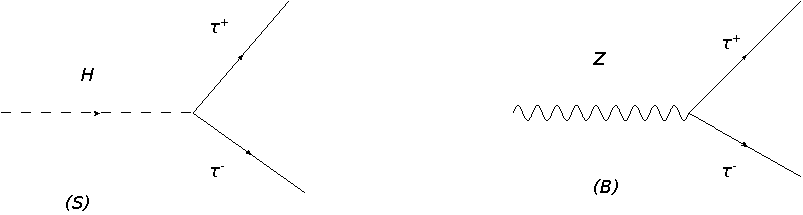

The $\tau$ leptons can then decay hadronically (h) or leptonically - so either an electron (e) or a muon ($\mu$) as shown below:

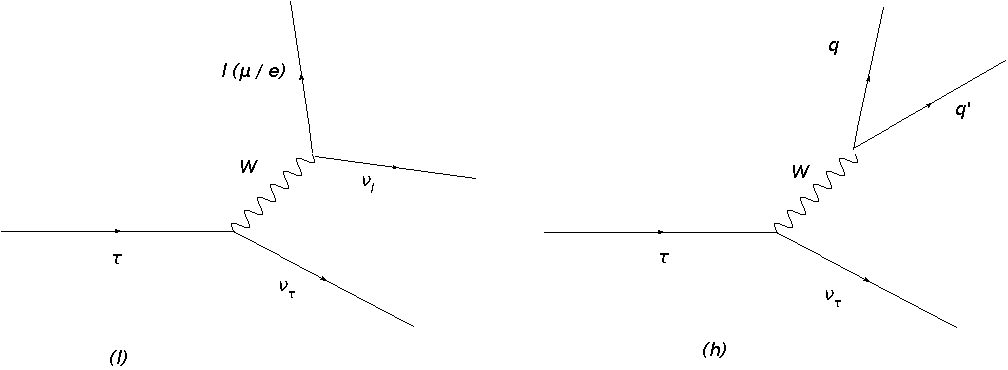

Now the Z boson has a mass of ~90 GeV and the Higgs boson a mass of ~125 GeV, so naively you would think that this would be easy, as you could just reconstruct all the particles and find the invariant mass. However, the problem is that we cannot reconstruct any of the neutrinos ($\nu$), so we have to use other variables as well.

There is a slight complication in that the Higgs can be produced in different ways. The most likely two being gluon fusion (ggH) and vector boson fusion (VBF). With ggH happening about 10 the rate of VBF, however VBF events have some topological structures that might help to identify them. The processes are shown below:

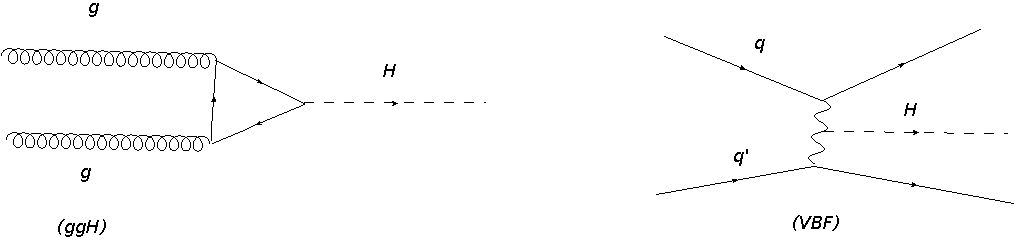


### About 2000 Z bosons are produced for every Higgs boson that is produced ###

## Datasets

You are given simulated MC datasets separated by decay channels:  where one $\tau$ has decayed to an electron and the other hadronically (et), where one $\tau$ has decayed to a $\mu$ and the other hadronically (mt), and where both have decayed hadronically (tt). 

They are also separated by process: Z bosons, Higgs from ggH and Higgs from VBF. 

In each of these datasets, there are a series of event variables which are explained below.


In [3]:
channels = ["et","mt","tt"]
processes = ["Z","ggH","VBF"]

dataset = {}
for channel in channels:
    dataset[channel] = {}
    for process in processes:
        url = f"https://raw.githubusercontent.com/gputtley/ML-Assessment-3/master/{channel}_{process}.pkl"
        dataset[channel][process] = pd.read_pickle(url)

An example of the tt channel DY events are shown below.

In [4]:
display(dataset["tt"]["Z"])

,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,mva_dm_2,n_deepbjets,n_jets,pt_1,pt_2,pt_tt,pt_vis,q_1,q_2,svfit_mass
0,2.414482,-9999.000000,2.373276,0.288935,-0.155231,-9999.000000,42.114372,-9999.000000,86.581536,30.150600,...,1.0,0.0,1.0,48.971975,42.047497,56.198355,34.711005,1.0,-1.0,122.340492
1,0.905428,105.572952,-0.870895,-1.301026,-1.053353,0.309145,202.115177,155.836621,47.121035,74.118637,...,0.0,0.0,3.0,67.624255,42.424370,167.510356,100.343648,-1.0,1.0,81.164604
2,1.786701,-9999.000000,-1.725332,-1.701998,-1.237745,-9999.000000,81.649279,-9999.000000,68.659531,24.880594,...,1.0,0.0,1.0,43.318895,43.055293,77.721734,56.179411,-1.0,1.0,90.083839
3,3.261100,-9999.000000,-3.132327,0.415204,-0.492155,-9999.000000,-9999.000000,-9999.000000,272.676875,79.535843,...,10.0,0.0,0.0,161.267835,94.447914,12.772213,66.829704,1.0,-1.0,394.964371
4,2.808269,44.089321,2.768047,-0.933327,-1.406919,0.360274,51.960214,24.052974,110.202417,13.298456,...,1.0,0.0,1.0,71.982552,41.230914,23.789963,36.810342,-1.0,1.0,121.641335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10554,2.434000,-9999.000000,-2.364294,-0.703203,-1.281535,-9999.000000,39.474594,-9999.000000,84.618685,10.248204,...,10.0,0.0,1.0,45.458845,41.776954,43.308454,33.232148,-1.0,1.0,103.120327
10555,0.650817,321.734161,-0.201372,0.496136,1.115016,0.998327,297.371251,40.722552,59.738937,107.629318,...,2.0,0.0,2.0,115.287050,70.994218,290.712892,185.391304,-1.0,1.0,86.510059
10556,1.468973,129.886017,1.302548,0.315466,0.994619,3.097943,163.557993,59.898794,89.913374,55.855453,...,2.0,0.0,3.0,74.985983,55.278327,149.554641,104.287329,1.0,-1.0,133.496468
10557,3.096478,-9999.000000,3.002873,0.769950,0.014352,-9999.000000,-9999.000000,-9999.000000,148.423309,33.579464,...,2.0,0.0,0.0,71.921759,66.870102,23.317015,10.859038,-1.0,1.0,163.827553


### Variables definitions
If a variable shown below ends with {1,2}, this means that the variable exists for both the tau decay products 1 and 2. 1 refers to the leading transverse momentum hadronic tau in tt channel and the electron or muon in the et or mt channel. 2 refers to the subleading transverse momentum hadronic tau in tt channel and the hadronic tau in the et and mt channel. Any variable that takes the value -9999 is undefined for that event.

- dR: Distance between the two tau decay products.
- dijetpt: Total transverse momentum of the two highest transverse momentum jets in the event.
- dphi: The angle phi between the two tau decay products.
- eta_{1,2}: The detector eta of the tau decay products.
- jdeta: The eta between the two highest transverse momentum jets in the event.
- jpt_1: The transverse momentum of the leading transverse momentum jet in the event.
- jpt_2: The transverse momentum of the subleading transverse momentum jet in the event.
- m_vis: The reconstructed mass of the visibile ditau decay products.
- met: The missing transverse energy in the event.
- met_dphi_{1,2}: The angle phi between the met and the tau decay product.
- mjj: The reconstructed mass of the two highest transverse momentum jets in the event.
- mt_{1,2}: The transverse mass between the met and the tau decay product.
- mt_lep: The transverse mass between the two tau decay products.
- mt_tot: The sum in quadrature of mt_1, mt_2 and mt_lep.
- mva_dm_{1,2}: The predicted decay mode of the hadronic tau (1 only available for tt channel).
- n_deepbjets: The number of b tagged jets in the event.
- n_jets: The number of jets in the events.
- pt_{1,2}: The transverse momentum of the tau decay product.
- pt_tt: The reconstructed ditau + met transverse momentum.
- pt_vis: The reconstructed ditau transverse momentum.
- q_{1,2}: The charge of the tau decay product.
- svfit_mass: A likelihood reconstruction of the ditau mass.

## Task

We want you to use simulated events to try to optimise a search for the signal Higgs bosons. To do this, you will need to attempt to separate the signal Higgs boson events from the background Z boson events. Your assignment is to produce a binning of the dataset that provides the most precise binned likelihood fit for the rate of the signal. The bins should be chosen by using the output of a machine learning algorithm.

Things you may want to try:
- Try both binary (S vs B) and multiclass (Z, ggH, VBF) classifiers.
- Try different machine learning classification models.
- Try training classifiers both on the decay channels (et, mt, tt) individually and merged into one dataset.
- Try building the histograms from the binary signal classifier score.
- Try building 2D histograms from the multiclass output scores.

## Classical solution

It is common in particle physics to compare the performance of a machine learning algorithm to that of a classical algorithm. This will act as a baseline solution, to show the improvement you can get with machine learning.

Here we show an example of using a binned m_vis histogram to measure the precision using a binned likelihood fit, where all channels are merged together.

First, we build the histograms.

In [5]:
bins = np.linspace(50,200,num=51)
variable = "m_vis"

combined_channels_dataset = {}
histograms = {}
for proc in processes:
  combined_channels_dataset[proc] = pd.concat([dataset[ch][proc] for ch in channels])
  histograms[proc] = np.histogram(combined_channels_dataset[proc].loc[:,variable], bins=bins)[0]

The current length of the simulated datasets do not represent the number of events expected. Therefore, we scale them to what is expected. In your studies, you should use the same function.

In [6]:
def scale_histograms_to_correct_yield(histograms):
  """
  Scale histograms for different processes to the expected yields.
  
  Args:
    histograms (dict): Dictionary of histograms with keys "Z", "ggH", "VBF".
                       Each value is a NumPy array representing bin counts.

  Returns:
    dict: The input dictionary with histograms scaled to the expected yields.
  """
  for proc in ["Z","ggH","VBF"]:
    histograms[proc] = histograms[proc].astype(float)
  # scaling factors:
  histograms["Z"] *= 8.4
  histograms["ggH"] *= 0.034
  histograms["VBF"] *= 0.011
  return histograms

In [7]:
scaled_histograms = scale_histograms_to_correct_yield(histograms)

We can then plot the histograms. Here we also scale up the signal (just for the plot) so it is visible.

In [8]:
def plot_histograms(hist, bins, x_label, title_right=None, scale_signal=10):
  """
  Plot stacked histograms for multiple processes with optional signal scaling.

  Args:
    hist (dict): Dictionary of histograms with process names as keys and
                 NumPy arrays of bin counts as values.
    bins (array-like): Bin edges for the histograms.
    x_label (str): Label for the x-axis.
    title_right (str, optional): Text displayed in the top-right corner of the plot.
    scale_signal (float, optional): Factor to scale signal histograms ("ggH" and "VBF")
                                    for better visibility on the plot. Set to None to disable.
  """
  hist = copy.deepcopy(hist)
  if scale_signal is not None:
    for sig_proc in ["ggH","VBF"]:
      hist[f"{scale_signal} x {sig_proc}"] = scale_signal*hist[sig_proc]
      del hist[sig_proc]

  if title_right is None:
    title_right = ""

  fig, ax = plt.subplots(1, 1, figsize=[8,6])
  rgb_palette = sns.color_palette("Set2", len(hist.keys()))
  step_edges = np.append(bins, 2*bins[-1]-bins[-2])

  for ind, (k, v) in enumerate(hist.items()):
    if ind == 0: bottom = None
    ax.bar(
      bins[:-1],
      v,
      bottom=bottom,
      width=np.diff(bins),
      align='edge',
      alpha=1.0,
      label=k,
      color=tuple(x for x in rgb_palette[ind]),
      edgecolor=None
    )
    if bottom is None:
      bottom = v*1.0
    else:
      bottom += v

    step_histvals = np.append(np.insert(bottom,0,0.0),0.0)
    ax.step(step_edges, step_histvals, color='black')

  ax.text(1.0, 1.0, title_right, verticalalignment='bottom', horizontalalignment='right',
          transform=ax.transAxes, fontsize=22)
  plt.ylim(10, np.max(bottom)*2)
  plt.xlim(bins[0], bins[-1])
  plt.xlabel(x_label)
  plt.ylabel("Events")
  plt.yscale('log')
  plt.legend(loc='upper right')
  plt.show()

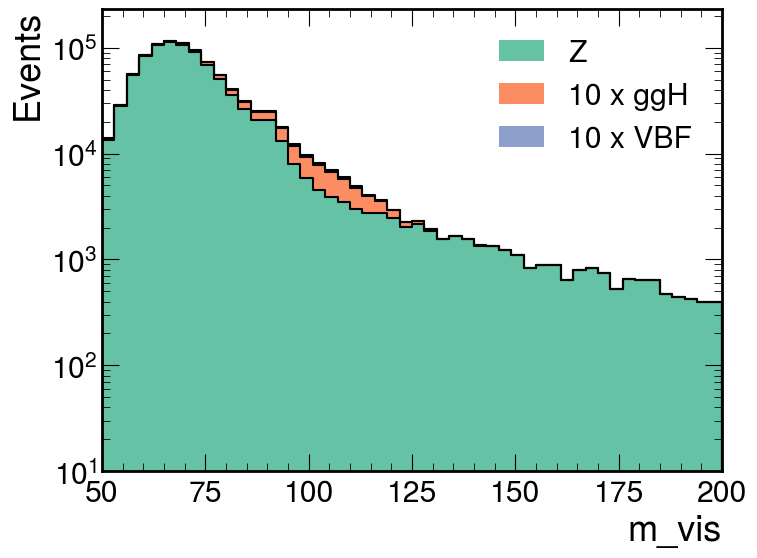

In [9]:
plot_histograms(scaled_histograms, bins, variable)

One thing we must check before doing a binned likelihood fit, is that we have enough events in every bin. If this steps is not passed, make the bins used coarser.

In [10]:
def check_events_numbers(histograms, threshold=10):
  """
  Check that each bin in the summed histograms has at least a minimum number of events.

  Args:
    histograms (dict): Dictionary of histograms with process names as keys and
                       NumPy arrays of bin counts as values.
    threshold (int, optional): Minimum number of events required in each bin. Default is 10.

  Raises:
    ValueError: If any bin in the summed histogram has fewer than `threshold` events.
  """
  summed_histogram = np.sum(list(histograms.values()), axis=0)
  if (summed_histogram < threshold).any():
    raise ValueError("Not enough events in one or more of the histogram bins")

In [11]:
check_events_numbers(scaled_histograms)

We have two choices for the type of fit.

The first is a fit for an inclusive signal strength modifier (that scales both the rate of ggH and VBF together).

The second is a fit for the signal strength modifiers mu_ggH (that scales the rate of the ggH process) and mu_VBF (that scales the rate of the VBF process) simultaneously.

As we are fitting for the expected values, the fit should return signal strength modifiers of approximately 1 with some uncertainty.

The metric we are interested in is the precision of the measurement of each signal strength modifier. This tells us to what precision we can measure the rate of that process. You want the percentage to be as small as possible.

We build two types of likelihood functions and we perform the fit with minuit.

In [12]:
def nll_merge(expected_counts_per_process, mu):
  """
  Compute the negative log-likelihood (NLL) assuming a single signal strength parameter
  for both ggH and VBF processes combined.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu (float): Signal strength multiplier applied to ggH and VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + (mu * (expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]))
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))


def nll_separate(expected_counts_per_process, mu_ggH, mu_VBF):
  """
  Compute the negative log-likelihood (NLL) using separate signal strength parameters
  for ggH and VBF processes.

  Args:
    expected_counts_per_process (dict): Dictionary with keys "Z", "ggH", "VBF" and
                                        values as expected bin counts (arrays).
    mu_ggH (float): Signal strength multiplier for ggH.
    mu_VBF (float): Signal strength multiplier for VBF.

  Returns:
    float: Negative log-likelihood value.
  """
  observed_counts = expected_counts_per_process["Z"] + expected_counts_per_process["ggH"] + expected_counts_per_process["VBF"]
  expected_counts = expected_counts_per_process["Z"] + (mu_ggH * expected_counts_per_process["ggH"]) + (mu_VBF * expected_counts_per_process["VBF"])
  return np.sum(expected_counts - observed_counts * np.log(expected_counts))

In [13]:
nll = partial(nll_merge, scaled_histograms)
m = Minuit(nll, mu=1.0)
m.migrad()
print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")

mu = 1.0 ± 0.1008


In [14]:
nll = partial(nll_separate, scaled_histograms)
m = Minuit(nll, mu_ggH=1.0, mu_VBF=1.0)
m.migrad()
print(f"mu_ggH = {round(m.values['mu_ggH'],4)} ± {round(m.errors['mu_ggH'],4)}")
print(f"mu_VBF = {round(m.values['mu_VBF'],4)} ± {round(m.errors['mu_VBF'],4)}")

mu_ggH = 1.0 ± 0.5694
mu_VBF = 1.0 ± 4.8929


This gives us a precision of ~10% on the total signal rate, and a precision of ~57% for ggH and ~490% for VBF.

This example is very basic and you get very poor performance for VBF. If you look closely at the simulated data you will see that VBF is more prominent when n_jets >= 2, jdeta > 2.5 and mjj > 200. Therefore, we define two orthogonal splits of the data, one that targets VBF events and one that targets ggH. We now apply all the same steps as we did in the previous example.

In [15]:
# Make histograms
vbf_like_query = "(n_jets >= 2) & (jdeta > 2.5) & (mjj > 200)"
variable = "m_vis"
vbf_like_bins, ggH_like_bins = np.linspace(50, 200, 21), np.linspace(50, 200, 51)

vbf_like_dataset = {p: combined_channels_dataset[p].query(vbf_like_query) for p in processes}
ggH_like_dataset = {p: combined_channels_dataset[p].query(f"not ({vbf_like_query})") for p in processes}

vbf_like_histograms = {p: np.histogram(vbf_like_dataset[p][variable], bins=vbf_like_bins)[0] for p in processes}
ggH_like_histograms = {p: np.histogram(ggH_like_dataset[p][variable], bins=ggH_like_bins)[0] for p in processes}

In [16]:
# Scale histograms
scaled_vbf_like_histograms = scale_histograms_to_correct_yield(vbf_like_histograms)
scaled_ggH_like_histograms = scale_histograms_to_correct_yield(ggH_like_histograms)

# Check binning is ok
check_events_numbers(scaled_vbf_like_histograms)
check_events_numbers(scaled_ggH_like_histograms)

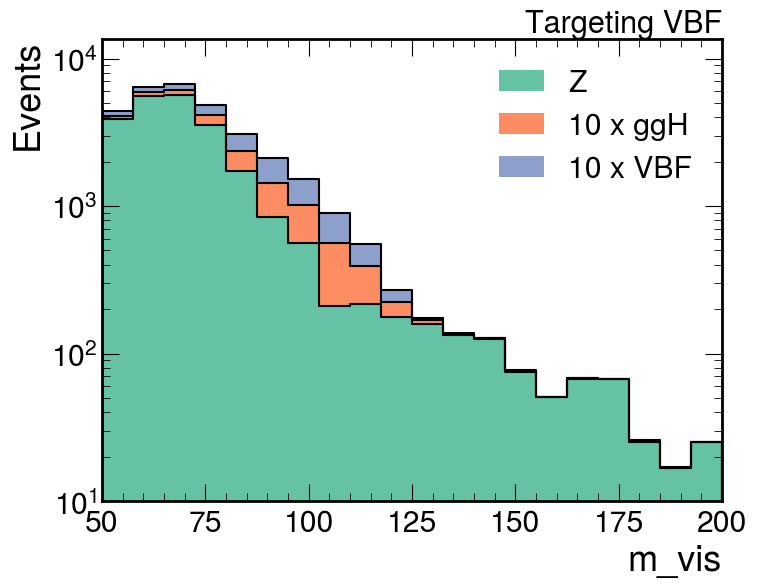

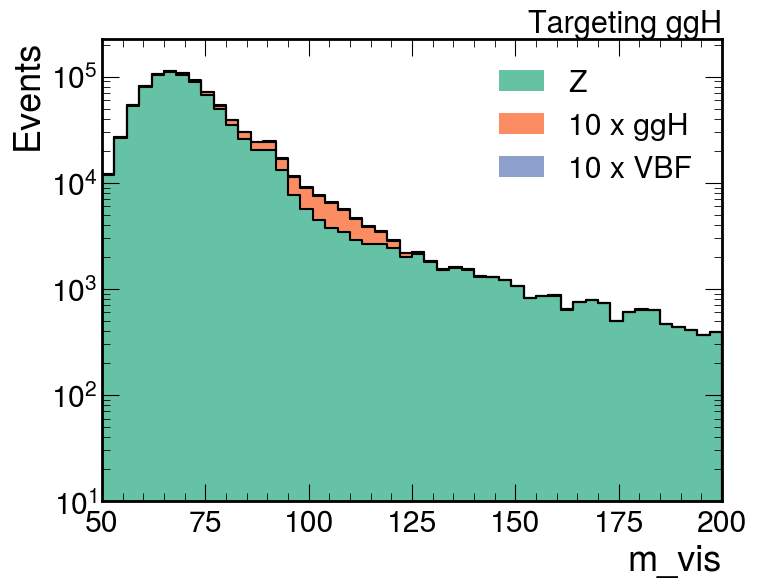

In [17]:
# Plot histograms
plot_histograms(scaled_vbf_like_histograms, vbf_like_bins, variable, title_right="Targeting VBF")
plot_histograms(scaled_ggH_like_histograms, ggH_like_bins, variable, title_right="Targeting ggH")

You can see that VBF is now visible in the plot! This is a good sign, we can now test the binning by performing the fits. As the histograms are from orthogonal splits in the data, we can concatenate the histograms for the binned likelihood fit.

In [18]:
# Concatenate histograms
concatenated_histograms = {proc: np.concatenate([scaled_vbf_like_histograms[proc], scaled_ggH_like_histograms[proc]]) for proc in processes}

In [19]:
# Run fit for mu
nll = partial(nll_merge, concatenated_histograms)
m = Minuit(nll, mu=1.0)
m.migrad()
print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")

mu = 1.0 ± 0.0923


In [20]:
# Run fit for mu_ggH and mu_VBF
nll = partial(nll_separate, concatenated_histograms)
m = Minuit(nll, mu_ggH=1.0, mu_VBF=1.0)
m.migrad()
print(f"mu_ggH = {round(m.values['mu_ggH'],4)} ± {round(m.errors['mu_ggH'],4)}")
print(f"mu_VBF = {round(m.values['mu_VBF'],4)} ± {round(m.errors['mu_VBF'],4)}")

mu_ggH = 1.0 ± 0.1249
mu_VBF = 1.0 ± 0.3578


This now does much better for ggH (57% -> 12%) and VBF (490% -> 35%). The multidimensionality of the dataset is important in optimising the Higgs boson search! But this is just a classical example that uses more than one variable. You can do much better with machine learning.

The CMS published analysis managed a statistical precision of:
   * mu_ggH: 9%
   * mu_VBF: 18%
   * mu: 6%

See if you can beat it!

## Your work

# Data Pre-Processing
## Handling Undefined Features (Value: `-9999`) - Imputation Strategy and Physics Motivation

Several variables in the tau–tau dataset take the value **`-9999`** when the corresponding quantity is *undefined*.

Dropping these rows would remove a large fraction of valid physics events, so I replaced undefined values with **physically meaningful substitutes** based on what the detector would effectively “see”.

Below are the variables, their imputation choices, and the **reasoning** behind each replacement.

---

## Tau-related Variables

| Variable | Replacement | Reason |
|---------|-------------|--------|
| `pt_1`, `pt_2` | `0` | If the tau is missing, the detector observes no visible momentum -> physically zero. |
| `eta_1`, `eta_2` | `0` | Missing direction -> place at detector centre; neutral and symmetric. |
| `dphi` | `0` | Undefined if either φ is missing; setting to 0 avoids introducing fake angular structure. |
| `dR` | `0` | Undefined angular distance -> 0 represents “no separation” (neutral placeholder). |
| `met_dphi_1`, `met_dphi_2` | `π/2` | If tau direction is missing, angle to MET is undefined -> use neutral angular value. |
| `m_vis` | `0` | Visible mass cannot be formed -> 0 is physically minimal and neutral. |
| `svfit_mass` | `0` | When SVFit fails, mass is undefined -> 0 represents “no reconstructed mass.” |
| `mt_1`, `mt_2`, `mt_lep`, `mt_tot` | `0` | Transverse mass uses angles and MET; undefined -> 0 (no transverse mass). |
| `mva_dm_1`, `mva_dm_2` | mode (most common value) | Decay mode missing -> impute with the most frequent valid category to preserve categorical balance. |
| `q_1`, `q_2` | `0` | Missing tau means no measured charge; 0 is a neutral placeholder. |

---

## Jet Variables

| Variable | Replacement | Reason |
|---------|-------------|--------|
| `jpt_1`, `jpt_2` | `0` | If jets are missing, their pT is genuinely 0. |
| `jdeta` | `0` | Δη undefined without two jets; neutral placeholder. |
| `mjj` | `0` | Dijet mass requires two jets; without them, mass collapses to 0. |
| `dijetpt` | `0` | No jets -> no dijet system -> transverse momentum = 0. |
| `n_jets`, `n_deepbjets` | `0` | Undefined jet counts replaced with 0 to mark absence of jets. |

---

## Combined Variables

| Variable | Replacement | Reason |
|---------|-------------|--------|
| `pt_vis` | `0` | Visible tau system cannot be reconstructed without two taus. |
| `pt_tt` | `0` | Tau+MET transverse momentum undefined -> 0 as neutral value. |

---

## Summary

- These imputations ensure no rows are dropped, preserving the full dataset.  
- Replacements reflect physical detector behaviour or neutral placeholders, rather than arbitrary constants.  
- Tree-based models like XGBoost can naturally handle these imputations, while other models (e.g., neural networks) require preprocessing to avoid instability.


First I'll import any necessary packages and then build a unified dataframe.

In [21]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

In [22]:
# Build unified dataframe (clean -9999) and split
processes = list(combined_channels_dataset.keys())  # adjust if needed

# build combined dataframe
dfs = []
for process in processes:
    df = combined_channels_dataset[process].copy()
    df["process"] = process
    # label for binary classification: treat ggH and VBF as signal, Z bosons as background
    if process.lower().startswith("ggh") or process.lower().startswith("vbf"):
        df["label_binary"] = 1
    else:
        df["label_binary"] = 0
    # for multiclass, a numeric label (0,1,2...)??
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

feature_cols = [c for c in df_all.columns if c not in ("process","label_binary")]

In [23]:
# Data pre-processing: HOW TO DEAL WITH -9999 VALUES IN DIFFERENT FEATURES
def impute_physics_features(df):
    """
    Impute undefined physics features (marked as -9999) with physically meaningful substitutes.

    Strategy:
    - MET–tau angles -> neutral angle (π/2)
    - Tau decay modes -> most common valid category (mode)
    - All other kinematic/jet variables -> 0 (represents "object missing")

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing physics features with possible -9999 values.

    Returns
    -------
    df : pandas.DataFrame
        Copy of the dataframe with -9999 values replaced according to the imputation rules.

    Notes
    -----
    See the Markdown section *Data Pre-Processing: Handling Undefined Features (-9999)* 
    for a detailed physics motivation behind each replacement choice.
    """
    df = df_all.copy()

    # MET–tau angles -> neutral angle
    met_angle_vars = ["met_dphi_1", "met_dphi_2"]
    df[met_angle_vars] = df[met_angle_vars].replace(-9999, np.pi / 2)

    # Decay modes -> use mode (most common)
    dm_vars = ["mva_dm_1", "mva_dm_2"]
    for col in dm_vars:
        mode_val = df.loc[df[col] != -9999, col].mode()[0]
        df[col] = df[col].replace(-9999, mode_val)

    # Everything else -> 0 (physically meaningful "object missing")
    zero_fill_vars = [
        "pt_1", "pt_2",
        "eta_1", "eta_2",
        "dphi", "dR",
        "m_vis", "svfit_mass",
        "mt_1", "mt_2", "mt_lep", "mt_tot",
        "q_1", "q_2",
        "n_jets", "n_deepbjets",
        "jpt_1", "jpt_2",
        "jdeta", "mjj", "dijetpt",
        "pt_vis", "pt_tt"
    ]

    df[zero_fill_vars] = df[zero_fill_vars].replace(-9999, 0)

    return df

df_all = impute_physics_features(df_all)

# Multiclass labelling and splitting (for later use)
proc_to_idx = {p:i for i,p in enumerate(processes)}
df_all["label_multi"] = df_all["process"].map(proc_to_idx)

# split
train_df, test_df = train_test_split(df_all, test_size=0.3, stratify=df_all["label_binary"], random_state=42)


## Feature Engineering

Here I displayed the distributions of all the features to see if there were any that were particularly important to pass into the model. While there were some (mjj, jdeta, met_dphi_1) that particularly highlighted VBF events (which are more difficult to isolate), I decided to pass all the features into the model so that it could decide itself what the important features were.

I copied the plot_histograms function from above but altered it so that I could plot the distributions in subplots.

In [24]:
def plot_histograms_ax(hist, bins, x_label, title_right=None, scale_signal=10, ax=None):
    """
    Plot stacked histograms for multiple processes with optional signal scaling.

    Args:
      hist (dict): Dictionary of histograms with process names as keys and
                   NumPy arrays of bin counts as values.
      bins (array-like): Bin edges for the histograms.
      x_label (str): Label for the x-axis.
      title_right (str, optional): Text displayed in the top-right corner of the plot.
      scale_signal (float, optional): Factor to scale signal histograms ("ggH" and "VBF")
                                      for better visibility on the plot. Set to None to disable.
      ax (matplotlib.axes.Axes, optional): Axis to plot into. If None, a new figure/axis is created.
    """

    hist = copy.deepcopy(hist)
    if scale_signal is not None:
        for sig_proc in ["ggH", "VBF"]:
            if sig_proc in hist:
                hist[f"{scale_signal} x {sig_proc}"] = scale_signal * hist[sig_proc]
                del hist[sig_proc]

    if title_right is None:
        title_right = ""

    # Use provided axis or create a new one
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[8, 6])

    rgb_palette = sns.color_palette("Set2", len(hist.keys()))
    step_edges = np.append(bins, 2 * bins[-1] - bins[-2])

    bottom = None
    for ind, (k, v) in enumerate(hist.items()):
        ax.bar(
            bins[:-1],
            v,
            bottom=bottom,
            width=np.diff(bins),
            align='edge',
            alpha=1.0,
            label=k,
            color=tuple(x for x in rgb_palette[ind]),
            edgecolor=None
        )
        if bottom is None:
            bottom = v * 1.0
        else:
            bottom += v

        step_histvals = np.append(np.insert(bottom, 0, 0.0), 0.0)
        ax.step(step_edges, step_histvals, color='black')

    ax.text(
        1.0, 1.0, title_right,
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12  # can change this font
    )
    ax.set_ylim(10, np.max(bottom) * 2)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_xlabel(x_label)
    ax.set_ylabel("Events")
    ax.set_yscale('log')
    ax.legend(loc='upper right', fontsize=8)

    # Only show if standalone
    if ax is None:
        plt.show()

    return ax


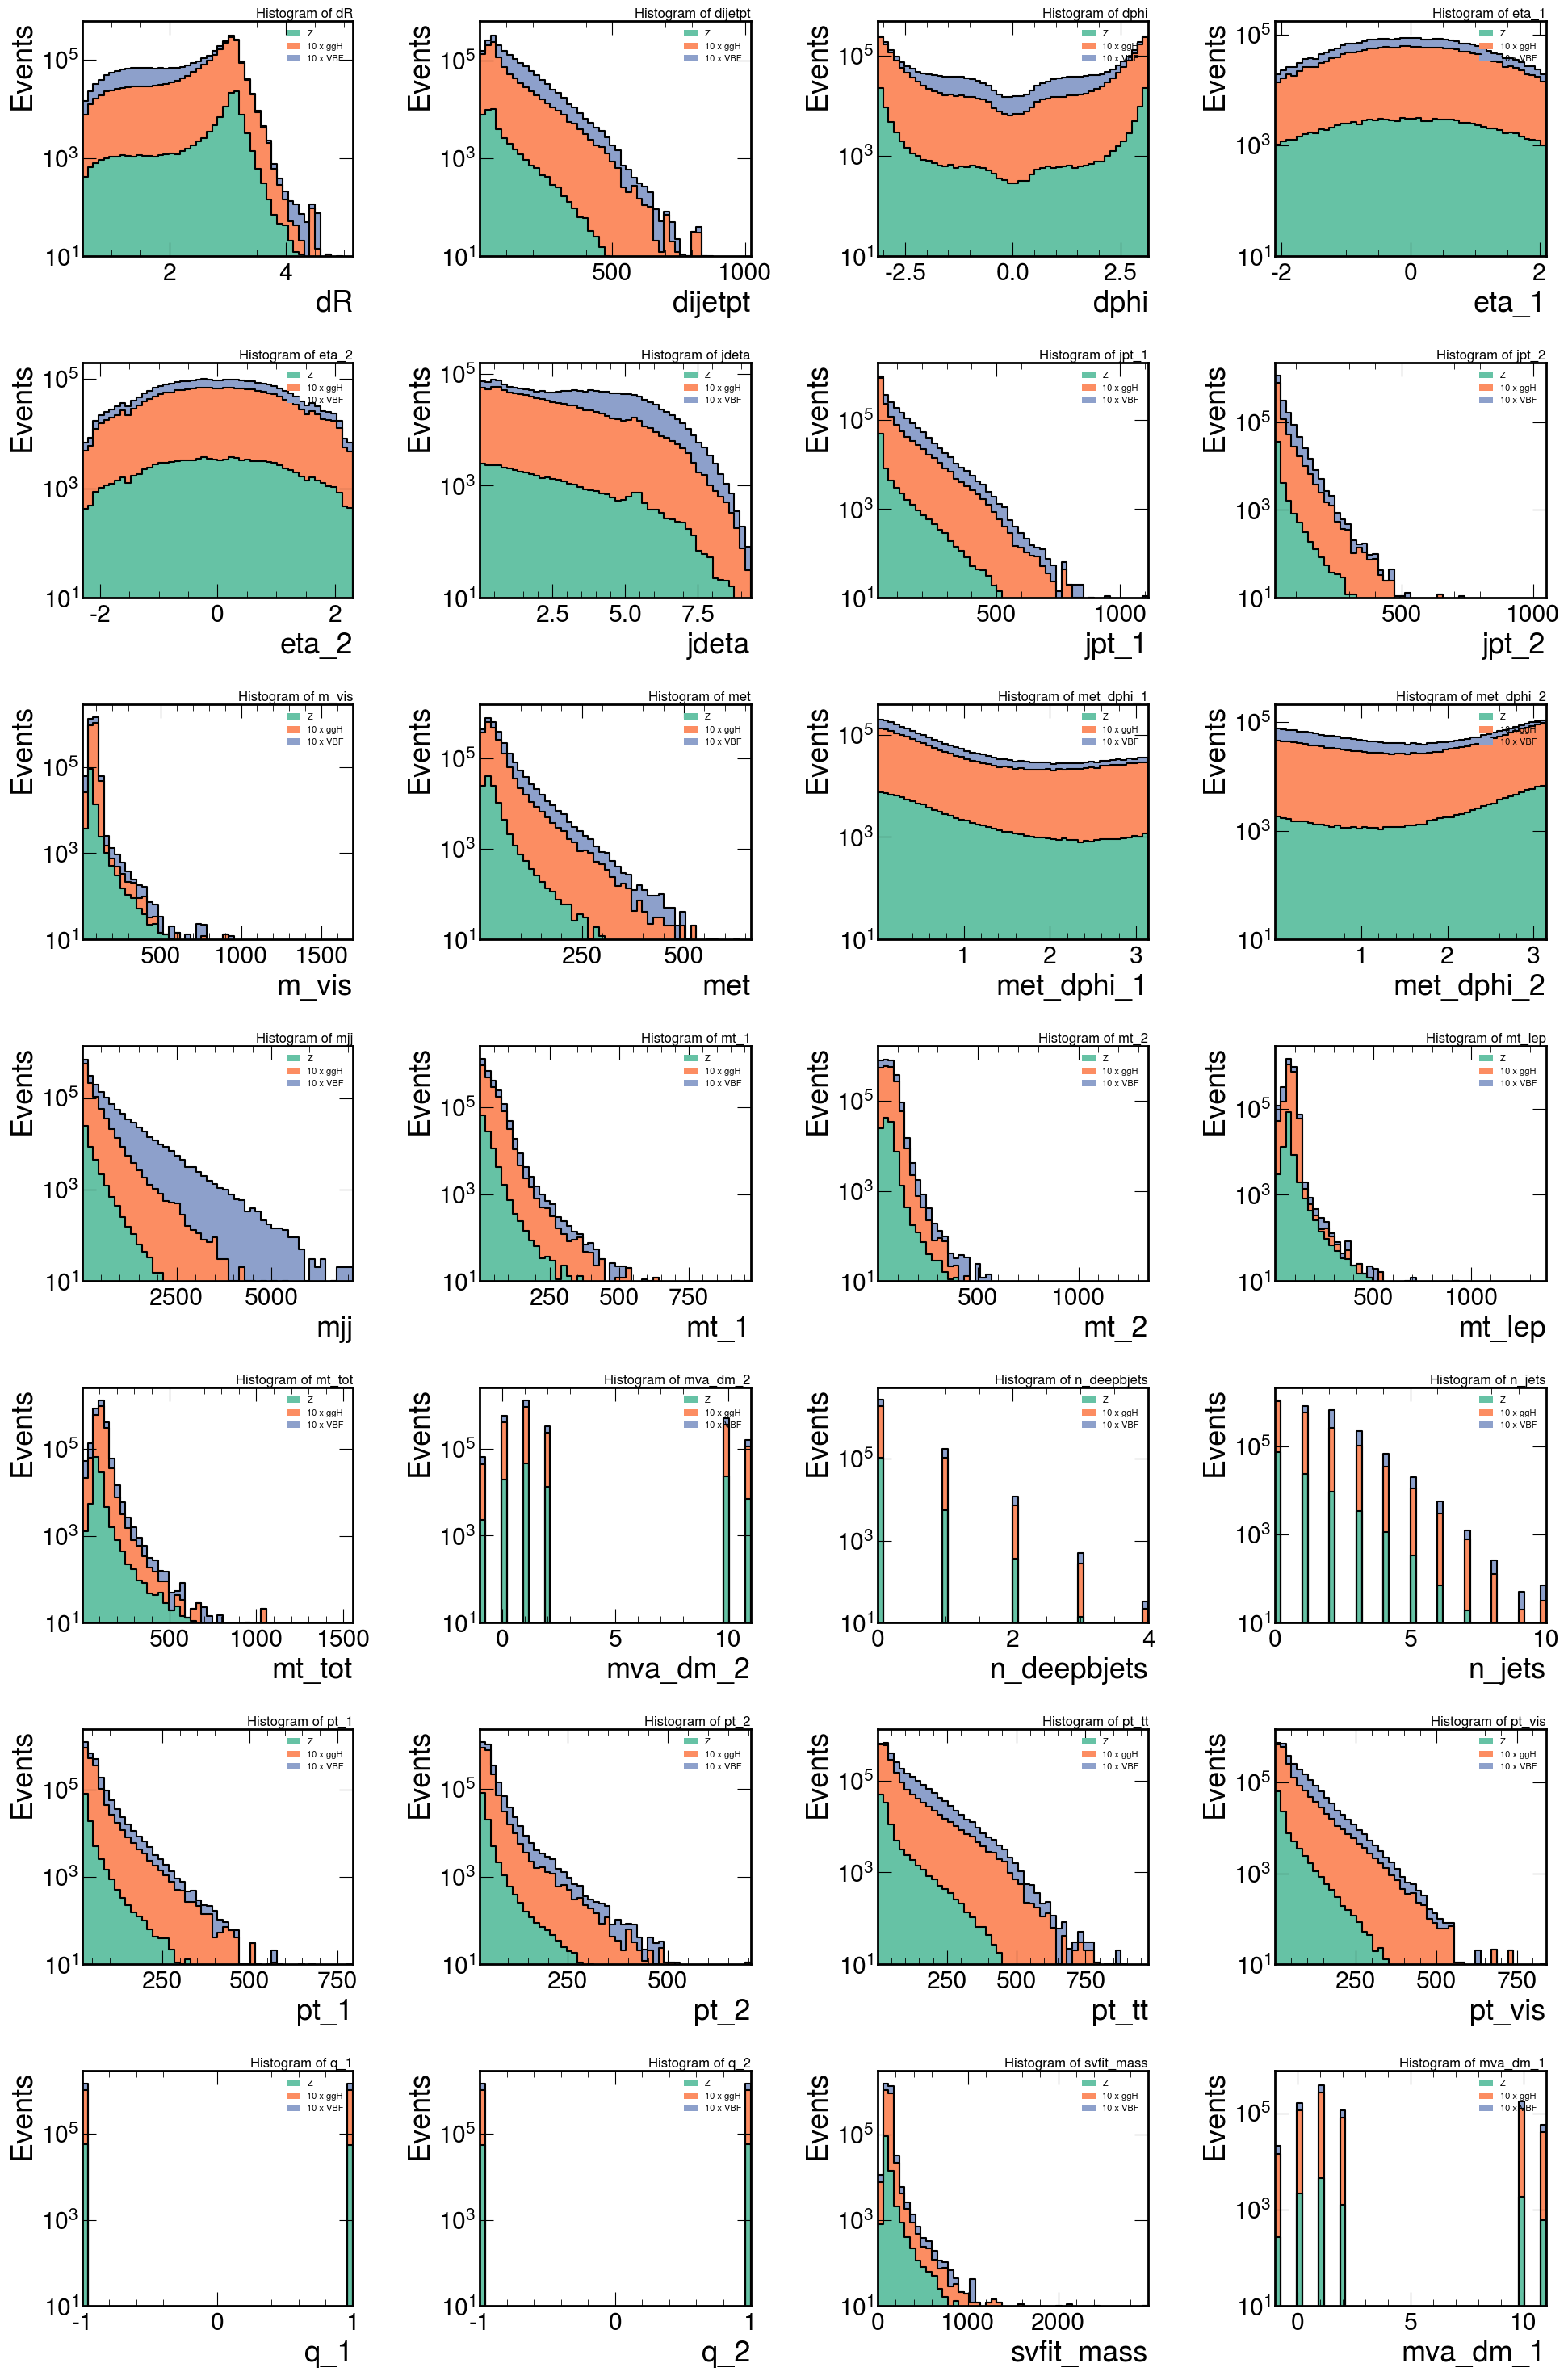

In [25]:
variables = combined_channels_dataset["Z"].columns  # 28 variables (this is fine because same for all processes)
n_vars = len(variables)

# Grid size
n_rows, n_cols = 7, 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()  # flatten to 1D array for easy indexing

# Plotting all features
for i, variable in enumerate(variables):
    ax = axes[i]

    # Concatenate data across processes
    data_concat = pd.concat([combined_channels_dataset[p][variable] for p in processes])
    data_concat = data_concat[data_concat != -9999]
    bins = np.linspace(data_concat.min(), data_concat.max(), 51)

    # Build histograms
    histograms = {
        proc: np.histogram(combined_channels_dataset[proc][variable], bins=bins)[0]
        for proc in processes
    }

    # Plot into the specific subplot axis
    plot_histograms_ax(
        histograms,
        bins=bins,
        x_label=variable,
        title_right=f"Histogram of {variable}",
        ax=ax  # <-- modify plot_histograms to accept an axis
    )

# Hide any unused subplots if n_vars < n_rows*n_cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Binary Classifier - Signal vs Background

As a starting point, I'll craft a binary classifier to predict events as the signal (Higgs boson) vs background (Z bosons).

This function trains a binary classification model (e.g., Logistic Regression, XGBoost, Random Forest) and evaluates its performance on a test dataset.  

### Key Steps
- **Data preparation:** Splits features (`feature_cols`) and binary labels (`label_binary`) into train and test sets.  
- **Model training:** Fits the chosen sklearn-compatible estimator on the training data.  
- **Predictions:** Generates probability scores (`predict_proba`) and class labels (`predict`).  
- **Performance metrics:**  
  - Accuracy score  
  - Confusion matrix  
  - Classification report (precision, recall, F1)  
  - ROC curve and AUC score  

In [26]:
def train_binary_classifier(model, train_df, test_df, feature_cols):
    """
    Function to train a sklearn binary classifier and evaluate performance.

    Parameters
    ----------
    model : sklearn estimator
        The ML model to train (LogisticRegression(), XGBClassifier(), RandomForestClassifier(), etc.)
    train_df, test_df : pandas DataFrame
        DataFrames containing features + label_binary
    feature_cols : list of str
        List of feature names to use for training

    Returns
    -------
    model : trained model
    results : dict with predictions and performance metrics
    """

    # Prepare data
    X_train = train_df[feature_cols].values
    y_train = train_df["label_binary"].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df["label_binary"].values

    # Train model
    print("Training model:", model.__class__.__name__)
    model.fit(X_train, y_train)

    # Get prediction scores (probabilities of signal)
    test_scores = model.predict_proba(X_test)[:, 1] 
    train_scores = model.predict_proba(X_train)[:, 1]

    # Predicted labels
    y_pred = model.predict(X_test)

    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # ROC/AUC
    auc = roc_auc_score(y_test, test_scores)
    fpr, tpr, _ = roc_curve(y_test, test_scores)

    # Pack results
    results = {
        "test_scores": test_scores,
        "train_scores": train_scores,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report,
        "auc": auc,
        "roc_curve": {"fpr": fpr, "tpr": tpr}
    }

    return model, results


## Model Selection: Tree-Based vs. Neural Network Approaches

In this analysis, I explored several classifiers to determine which provided the most robust and precise performance on the dataset. The primary focus was on **tree-based methods** (Random Forests, XGBoost, and gradient boosting variants), since these models are particularly well-suited for handling missing values (`NaN`s). Tree-based algorithms can learn default split directions or treat missing entries as a separate branch during training, which allowed me to train models without extensive preprocessing or imputation.

An important observation was that **changing or imputing NaN values significantly altered the dataset**. When I replaced missing entries with statistical estimates (e.g., mean or median), the distribution of several features shifted, which in turn affected the learned decision boundaries. In contrast, leaving NaNs in place and letting the tree methods handle them directly preserved the natural structure of the data and often led to more stable performance.

For models that cannot handle NaNs (such as neural networks), I experimented with preprocessing. Median imputation proved difficult to integrate cleanly, so I instead dropped rows containing NaNs for those runs. Even with this adjustment, the neural network did not outperform the tree-based methods. **XGBoost consistently delivered the best precision and stability**, so I selected it as the primary classifier for the remainder of the analysis.

### Models Tested

- **XGBoost Classifier**  
  Tuned with 400 estimators, learning rate of 0.05, and max depth of 5.  
  **Pros:**  
  - Handles missing values (`NaN`s) natively, avoiding the need for imputation.  
  - Strong performance with structured data and complex feature interactions.  
  - Flexible tuning options (learning rate, subsampling, column sampling) to balance bias/variance.  

  **Cons:**  
  - More computationally intensive than simpler models.  
  - Requires careful hyperparameter tuning to avoid overfitting.  

- **Random Forest Classifier**  
  Configured with 300 trees and max depth of 6.  
  **Pros:**  
  - Robust to noisy features and less sensitive to hyperparameter choices.  
  - Easy to interpret feature importance.

  **Cons:**  
  - Typically less precise than boosting methods like XGBoost.  
  - Larger ensembles can become memory-heavy.  

- **Neural Network (MLPClassifier)**  
  Two hidden layers (64, 32) with ReLU activation and Adam optimizer.  
  Required dropping `NaN` rows, which reduced dataset size and precision.  
  **Pros:**  
  - Can model highly non-linear relationships.  
  - Flexible architecture allows experimentation with depth and width.  
  - Potentially powerful if trained on large, clean datasets.  

  **Cons:**  
  - Cannot handle missing values directly; requires imputation or dropping rows.  
  - More sensitive to hyperparameters and training stability.


In [27]:
from xgboost import XGBClassifier

xgb_model_1 = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05, # 0.05 best learning rate
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.9,
)

xgb1_clf, xgb1_results = train_binary_classifier(
    xgb_model_1,
    train_df, test_df,
    feature_cols
)

Training model: XGBClassifier


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,   # number of trees
    max_depth=6,        # limit tree depth to avoid overfitting
    random_state=42,
    n_jobs=-1           # use all CPU cores
)

rf_clf, rf_results = train_binary_classifier(
    rf_model,
    train_df, test_df,
    feature_cols
)


Training model: RandomForestClassifier


In [29]:
from sklearn.neural_network import MLPClassifier

# because nan values are an issues
train_df_nn = train_df.dropna()
test_df_nn  = test_df.dropna()

nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # two hidden layers
    activation="relu",            # non-linear activation
    solver="adam",                # optimizer
    alpha=1e-4,                   # L2 regularization
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)

nn_clf, nn_results = train_binary_classifier(
    nn_model,
    train_df_nn, test_df_nn,
    feature_cols
)


Training model: MLPClassifier


## Plotting Binary Classifier Results

To evaluate the performance of each binary classifier, I defined a helper function `plot_binary_results`.  
This function takes the output dictionary from `train_binary_classifier` and produces two key visualizations:

- **Confusion Matrix (left panel):**  
  A heatmap showing the counts of true positives, true negatives, false positives, and false negatives.  
  This helps visualize misclassifications and the balance between classes.

- **ROC Curve (right panel):**  
  Plots the True Positive Rate (TPR) against the False Positive Rate (FPR) across different thresholds.  
  The Area Under the Curve (AUC) is displayed in the legend, providing a single metric of classifier performance.

In addition to the plots, the function prints the **classification report** (precision, recall, f1-score, and support) for the given model.


In [30]:
def plot_binary_results(results, model_name="Model"):
    """
    Plot confusion matrix and ROC curve for a binary classifier.

    Parameters
    ----------
    results : dict
        Output from train_binary_classifier containing:
        - confusion_matrix
        - classification_report
        - auc
        - roc_curve (dict with fpr, tpr)
    model_name : str
        Name of the model (for plot titles)
    """
    conf_matrix = results["confusion_matrix"]
    auc = results["auc"]
    fpr = results["roc_curve"]["fpr"]
    tpr = results["roc_curve"]["tpr"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Confusion Matrix ---
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{model_name} Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # --- ROC Curve ---
    axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}", color="darkorange")
    axes[1].set_title(f"{model_name} ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(results["classification_report"])


## Performance Metrics for Different Binary Models

The comparison of performance metrics and visualizations makes it clear that **XGBoost consistently outperforms** the other two models across multiple evaluation criteria. Both the confusion matrix and ROC curve highlight its superior ability to distinguish between classes, with fewer misclassifications and a noticeably higher AUC score.  

When comparing overall accuracy:
- **XGBoost** achieved **84%**, with balanced performance across signal and background.  
- **Random Forest** reached **82%**, slightly lower due to weaker background recall.  
- **Neural Network** reported a seemingly high **92%**, but this was misleading — the confusion matrix showed that it classified the vast majority of events as signal, resulting in poor background performance.  

When comparing the area under the ROC curve (AUC) across models:
- **XGBoost** achieved an AUC of **0.894**, the highest among the three.  
- **Random Forest** followed with an AUC of **0.879**, showing solid but slightly weaker separation power.  
- **Neural Network** reached an AUC of **0.877**, close to Random Forest but still below XGBoost.  

These results demonstrate that while all three models provided good predictive performance, their relative stability and discriminating power varied. XGBoost not only delivered the strongest separation between signal and background but also benefited from its native handling of missing values (`NaN`s), which avoided the need for imputation or dropping rows. In contrast, the neural network required dropping rows with missing values, reducing the effective dataset size and contributing to its poor background classification despite high reported accuracy. Random Forest performed reasonably well but not as well as XGBoost.

---

## Classification Report Highlights
- **XGBoost**
  - Accuracy **84%**
  - Strong signal performance: precision **0.88**, recall **0.90**, F1 **0.89**
  - Background recall slightly lower (**0.68**), but overall balanced metrics

- **Random Forest**
  - Accuracy **82%**
  - Good signal recall (**0.91**), but weaker background recall (**0.60**)
  - Lower F1 for background (**0.66**) compared to XGBoost

- **Neural Network**
  - Accuracy **92%** (inflated by dataset reduction and signal bias)
  - Very strong signal metrics (precision **0.94**, recall **0.98**, F1 **0.96**)
  - Background recall only **0.46**, reflecting instability and poor separation in the confusion matrix

---

Given XGBoost’s superior accuracy, balanced classification, and effective handling of missing data, I decided to focus the remainder of the analysis on this model alone. This ensures that the conclusions drawn are based on the most reliable and precise classifier available in this study.



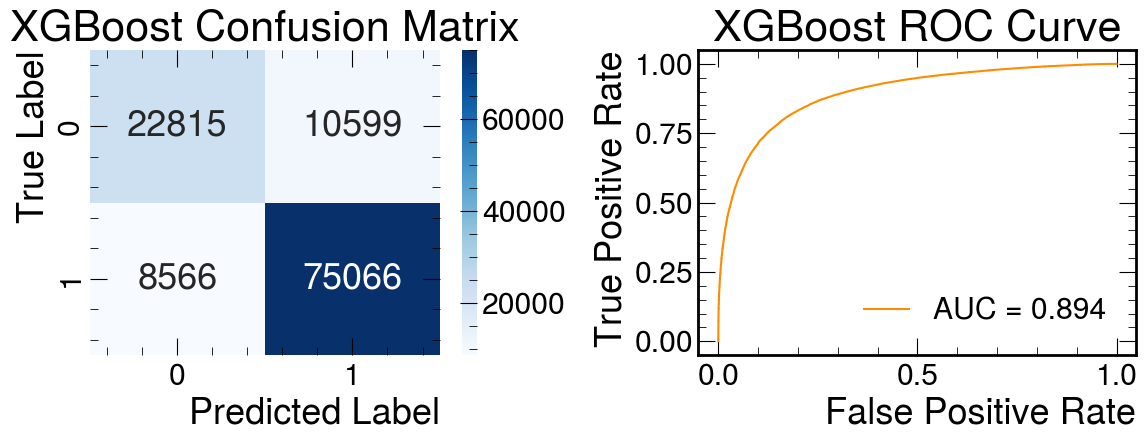


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.73      0.68      0.70     33414
           1       0.88      0.90      0.89     83632

    accuracy                           0.84    117046
   macro avg       0.80      0.79      0.80    117046
weighted avg       0.83      0.84      0.83    117046



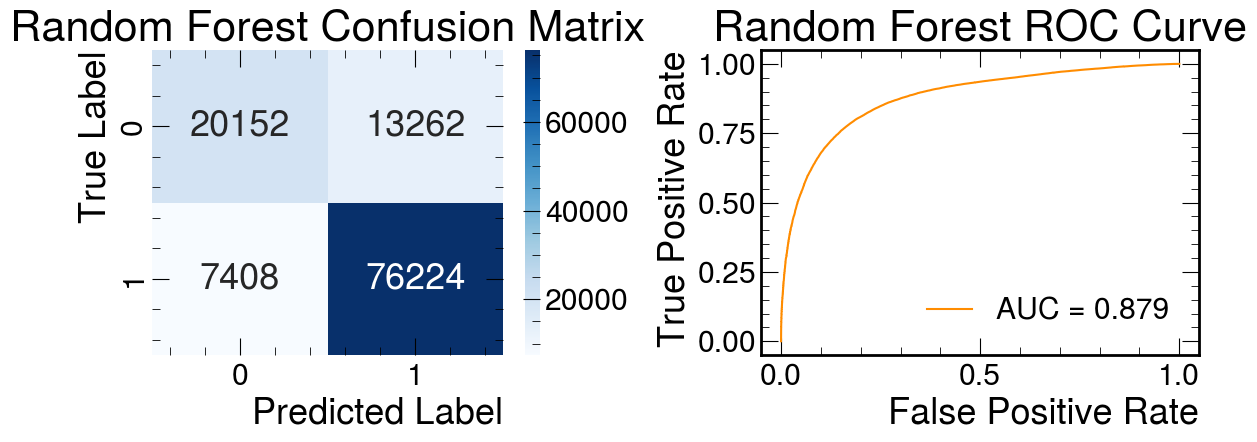


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.73      0.60      0.66     33414
           1       0.85      0.91      0.88     83632

    accuracy                           0.82    117046
   macro avg       0.79      0.76      0.77    117046
weighted avg       0.82      0.82      0.82    117046



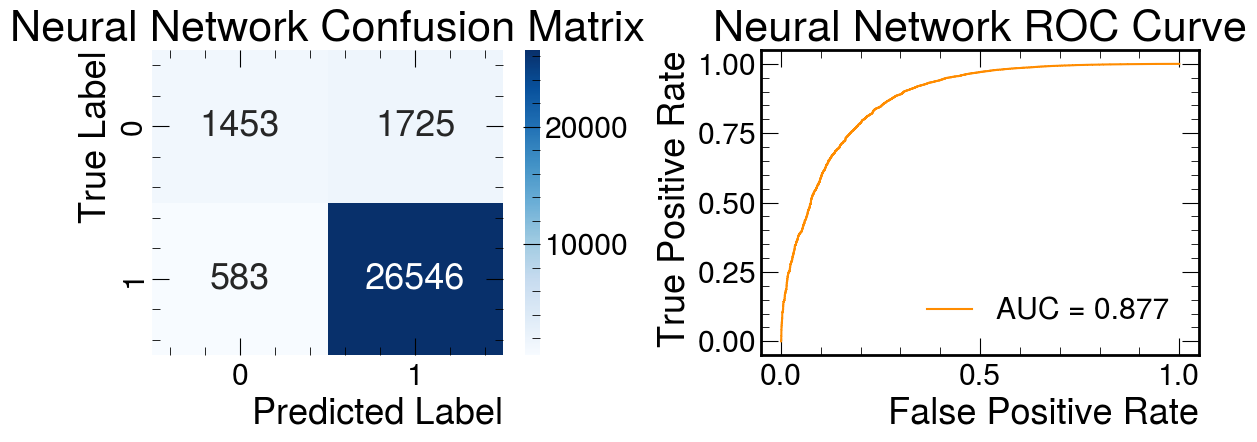


Classification Report for Neural Network:

              precision    recall  f1-score   support

           0       0.71      0.46      0.56      3178
           1       0.94      0.98      0.96     27129

    accuracy                           0.92     30307
   macro avg       0.83      0.72      0.76     30307
weighted avg       0.92      0.92      0.92     30307



In [31]:
# Plot results
plot_binary_results(xgb1_results, model_name="XGBoost")
plot_binary_results(rf_results, model_name="Random Forest")
plot_binary_results(nn_results, model_name="Neural Network")


## Feature Importance Plots

Feature importance plots provide a visual summary of how each model prioritizes input variables during classification.  
For tree-based methods such as **XGBoost** and **Random Forest**, the importance scores are derived from how often and how effectively a feature is used to split the data across all trees.

- **XGBoost**:  
  Utilized all available features at some point in its decision-making. The plot shows a broad distribution of importance, with `svfit_mass` emerging as the most dominant feature, followed by variables like `dR`. This reflects XGBoost’s ability to capture complex interactions across the full feature set.

- **Random Forest**:  
  Assigned zero importance to several features, indicating that some variables were not used at all in the ensemble splits. While `svfit_mass` was again the most important, the next most relevant features differed from XGBoost (e.g., `m_vis`), highlighting how different algorithms interpret feature relevance differently.

- **Neural Network (MLPClassifier)**:  
  No feature importance plot was generated. Neural networks do not provide native importance scores in the same way tree-based models do, and the need to drop rows with missing values (`NaN`s) reduced the dataset size, making feature interpretation less reliable.

The plots underscore the interpretability advantage of tree-based methods. Both XGBoost and Random Forest identified `svfit_mass` as the leading discriminant, but diverged in their secondary feature rankings. XGBoost’s broader use of features suggests it was able to leverage more of the dataset’s structure, which aligns with its superior performance in precision fits.


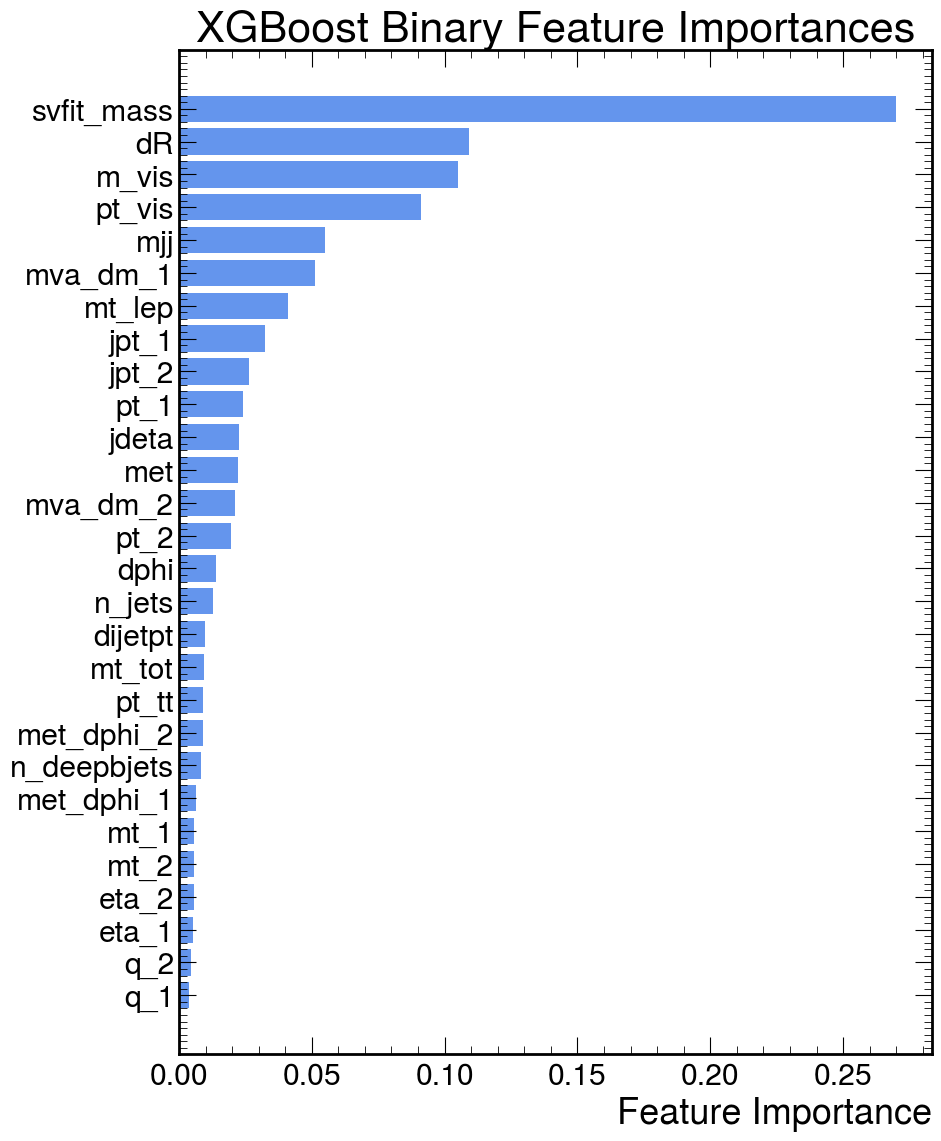

In [32]:
# Get feature importances from the trained model
importances = xgb_model_1.feature_importances_
feature_names = feature_cols

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10,12))
plt.barh(sorted_features, sorted_importances, color="cornflowerblue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Binary Feature Importances")
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()

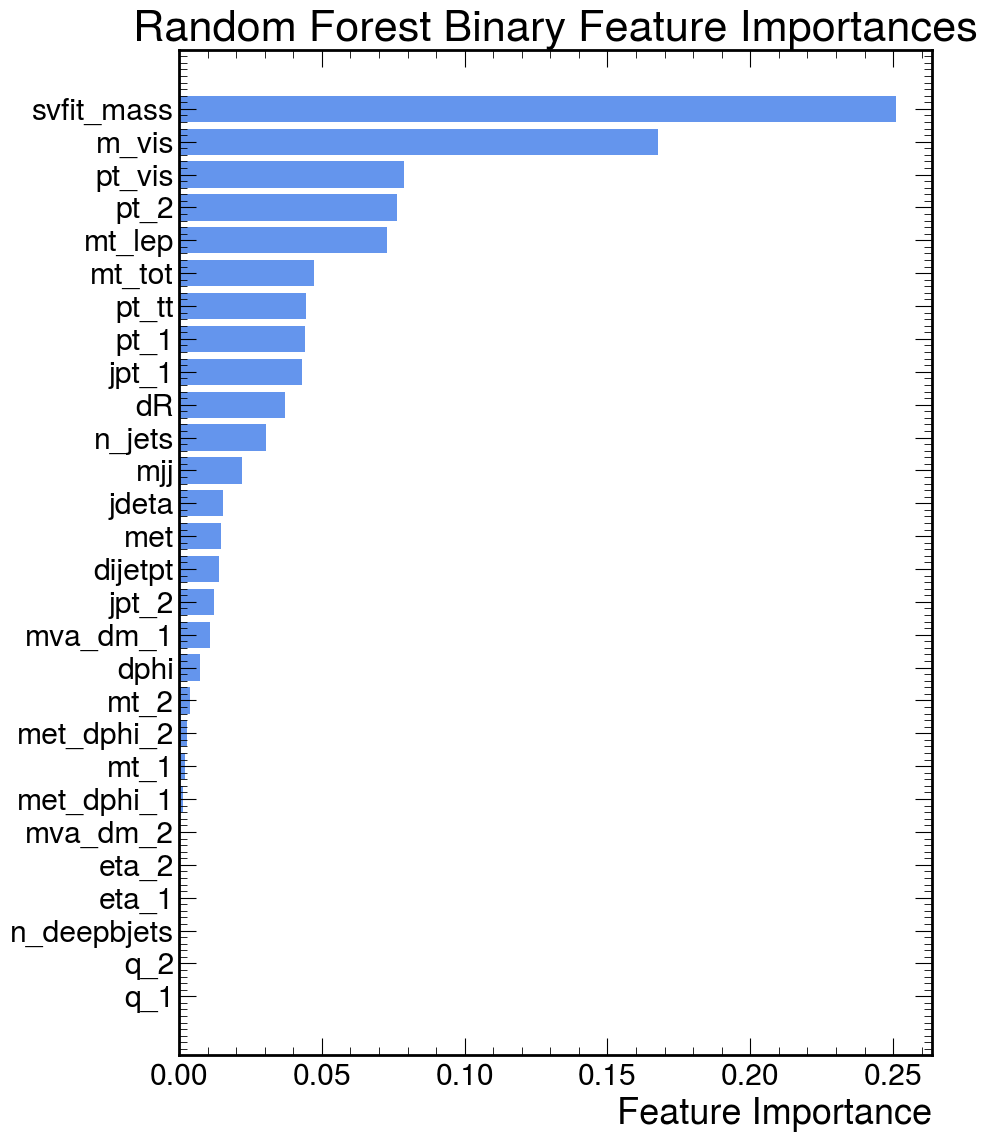

In [33]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = feature_cols

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10,12))
plt.barh(sorted_features, sorted_importances, color="cornflowerblue")
plt.xlabel("Feature Importance")
plt.title("Random Forest Binary Feature Importances")
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()

## Adding Classifier Scores as a Variable

I then added the classifier scores back into the main dataframe so they could be used as inputs for subsequent fitting procedures. This allowed me to keep track of the model outputs alongside the original event information. To better understand how the classifier was separating the two classes, I plotted the distributions of signal and background events below. The resulting histograms gave me a clear picture of the separation and the overall shape of the score distribution that I was expecting to see. These plots were used purely for diagnostic and visualization purposes - I did not perform any fitting directly on this histogram, but instead relied on the scores themselves for the formal analysis.

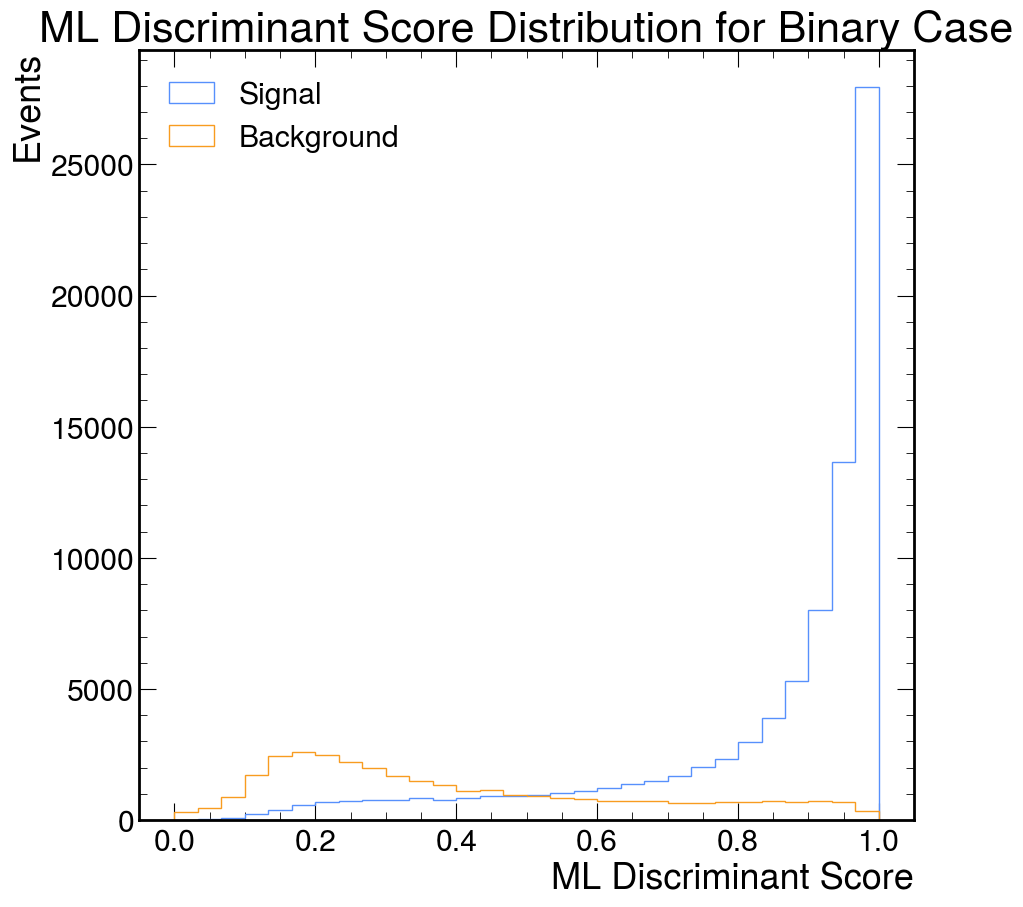

In [34]:
# Now adding classifier scores back into the dataframe for use as a discriminant variable:
test_df["ml_score"] = xgb1_results["test_scores"] # hyperparameter-tuned XGB
train_df["ml_score"] = xgb1_results["train_scores"]

# choose binning
bins = np.linspace(0, 1, 31)   # 30 bins between 0 and 1

signal = test_df.loc[test_df["label_binary"] == 1, "ml_score"]
background = test_df.loc[test_df["label_binary"] == 0, "ml_score"]

plt.hist(signal, bins=bins, histtype="step", density=False, label="Signal")
plt.hist(background, bins=bins, histtype="step", density=False, label="Background")
plt.title("ML Discriminant Score Distribution for Binary Case")
plt.xlabel("ML Discriminant Score")
plt.ylabel("Events")
plt.legend()
plt.show()

## Full Dataset Combination and Likelihood Fit

Here I combined the training and test datasets, built histograms of the ML score for each physics process, scaled them to the expected yields, and performed a likelihood fit to extract the signal strength parameter μ.

**Steps:**
1. **Combine dataframes**: Merge `train_df` and `test_df` into a single `full_df`. Note that this is particularly important for precise fitting as CMS and the classical example fit on the full dataset - if I didn't do this and fitted only on the test dataframe, the precision would be a lot worse.
2. **Choose binning**: Define ML score bins (here, 200 bins between 0 and 1).
3. **Build histograms per process**: Compute histograms of `ml_score` for VBF, ggH, and Z events.
4. **Scale histograms**: Apply the actual yield scaling using `scale_histograms_to_correct_yield`.
5. **Prepare expected counts**: Store scaled histograms in the format expected by the likelihood function.
6. **Observed counts**: Build a histogram of the full dataset’s ML scores.
7. **Plot comparison**: Overlay scaled templates with observed counts for visual validation.
8. **Likelihood fit**: Use `Minuit` to minimize the negative log-likelihood (`nll_merge`) and extract μ.
9. **Results**: Print the fitted μ value and its uncertainty.

This cell ensures that the ML score distributions from all processes are consistently scaled and compared to the observed data, providing a robust input to the likelihood fit.


## Choosing the Number of Bins

The number of bins directly affects both the precision of the histograms and the stability of the fits.

### More bins
- **Pros:** Higher resolution, captures fine structure in the ML score distribution, improves sensitivity to subtle differences between processes.
- **Cons:** Risk of sparse bins with few events, leading to statistical noise and unstable likelihood fits.

### Fewer bins
- **Pros:** More events per bin, smoother templates, more stable fits.
- **Cons:** Loss of detail, possible dilution of sharp features, reduced discriminating power.

### What I did
- Used **200 bins** over the ML score range.
- This provided good precision while still ensuring a sufficient number of events per bin (avoiding empty or noisy bins).
- The balance was important: enough bins to resolve differences between Z, ggH, and VBF, but not so many that the fit became unstable.


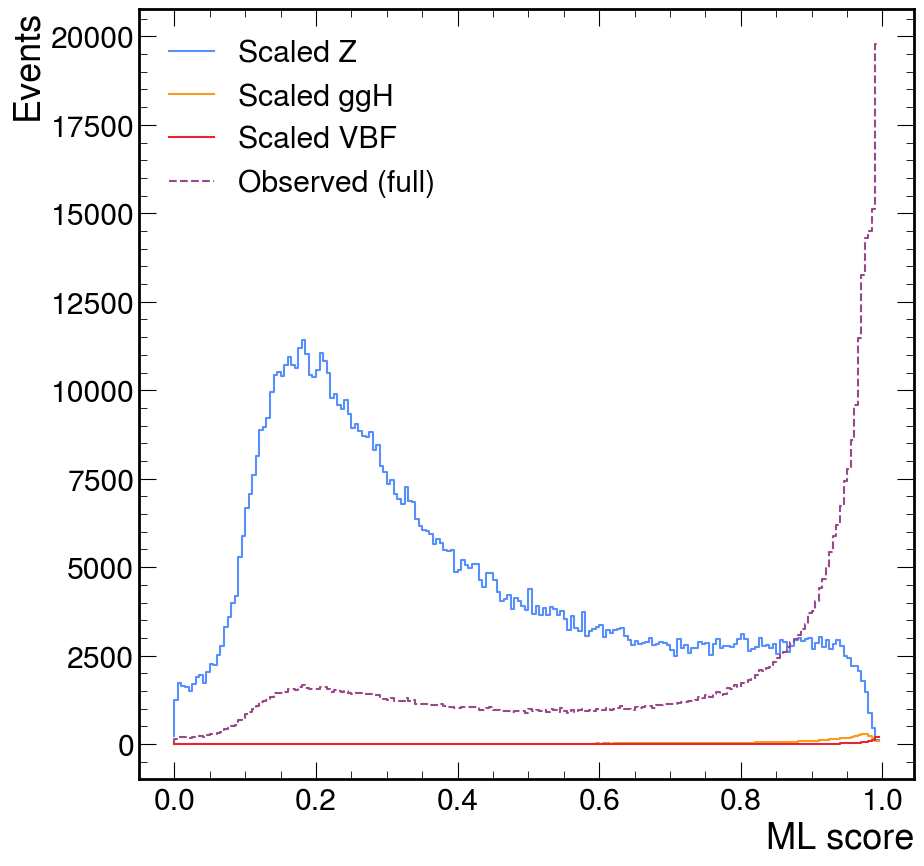

Fit: μ = 1.0000 ± 0.0527


In [35]:
# combine dataframes
full_df = pd.concat([train_df, test_df], ignore_index=True)

# can vary bins for more precise fit
bins = np.linspace(0, 1, 201)

# build histograms per process from the whole dataset
hist_vbf, _ = np.histogram(full_df.loc[full_df["process"] == "VBF", "ml_score"], bins=bins)
hist_ggh, _ = np.histogram(full_df.loc[full_df["process"] == "ggH", "ml_score"], bins=bins)
hist_z,   _ = np.histogram(full_df.loc[full_df["process"] == "Z",   "ml_score"], bins=bins)

# putting in dictionary
histograms = {"VBF": hist_vbf, "ggH": hist_ggh, "Z": hist_z}

# scale to physics yields (using given scaler function)
scaled_histograms = scale_histograms_to_correct_yield(histograms)

# check sufficient events in each bin
check_events_numbers(scaled_histograms)

# expected counts per process (same order the nll_merge function expects)
expected_counts_per_process = {
    "Z":   scaled_histograms["Z"],
    "ggH": scaled_histograms["ggH"],
    "VBF": scaled_histograms["VBF"]
}

# observed counts: histogram of the whole dataset's ml_score
observed_counts, _ = np.histogram(full_df["ml_score"], bins=bins)

# plot the scaled histograms and observed counts
plt.step(bins[:-1], scaled_histograms["Z"],   label="Scaled Z")
plt.step(bins[:-1], scaled_histograms["ggH"], label="Scaled ggH")
plt.step(bins[:-1], scaled_histograms["VBF"], label="Scaled VBF")
plt.step(bins[:-1], observed_counts,         label="Observed (full)", linestyle='--')
plt.xlabel("ML score")
plt.ylabel("Events")
plt.legend()
plt.show()

# NLL and fit (copying the classical example)
nll = partial(nll_merge, scaled_histograms)
m = Minuit(nll, mu=1.0)
m.migrad()

mu_hat  = m.values["mu"]
mu_err  = m.errors["mu"]
print(f"Fit: μ = {mu_hat:.4f} ± {mu_err:.4f}")


## Orthogonal ML-Score Split and Concatenation

In this experiment, the dataset was divided into **two orthogonal regions** based on an ML-score threshold of **0.85**.

Separate histograms were produced for each process (Z, ggH, VBF) in each region, scaled independently to their expected yields, and then concatenated to form a single set of templates for the likelihood fit. This mirrors the **classical analysis strategy**, where different regions (signal-enriched vs. background-dominated) are treated separately but combined in the final statistical model. While I could've chosen a higher cut that would have increased the precision, I felt it was important that the signal strength in the histogram below the threshold was low, which was not true for some higher cut values.

### Motivation
- The ML-score split at **0.85** was chosen because it provided the best fit behaviour in threshold scans.
- The split isolates a **signal-enhanced region** (ML > 0.85) from a **background-dominated region** (ML ≤ 0.85).
- Concatenating the two regions allows the likelihood to use both simultaneously while preserving their distinct signal-to-background characteristics.

### Outcome
- The split-and-concatenate method **improved the final measurement precision**, reducing the fitted signal-strength uncertainty to **0.052**, compared to the unified-histogram baseline.
- The gain comes from allowing the fit to treat the high-score region separately, where the signal fraction is much higher.
- This gives the model more flexibility and captures differences in shape and normalisation that a single 1D histogram could not represent as cleanly.

### Conclusion
Unlike the purely unified ML-score histogram, the orthogonal split introduced additional discriminating power by leveraging the distinct signal-to-background compositions of the two regions. For this ML-based method, the **0.85 split** provided a measurable improvement in precision while keeping the modelling complexity manageable.



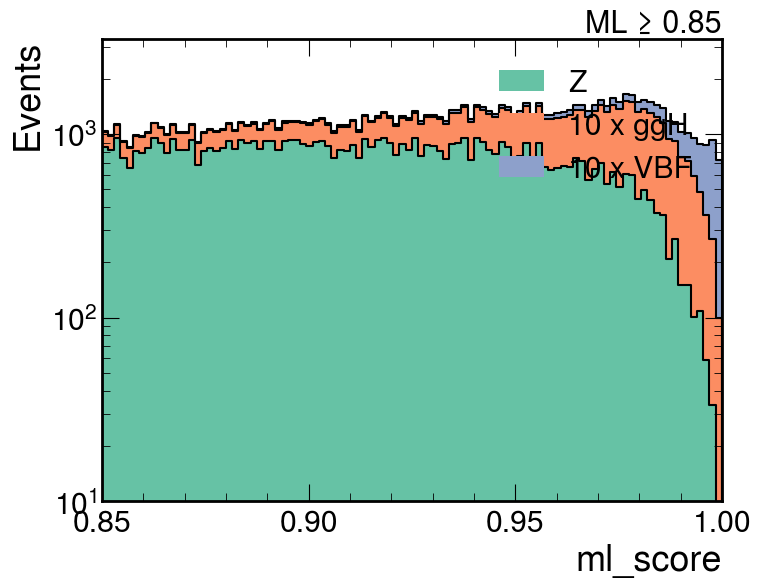

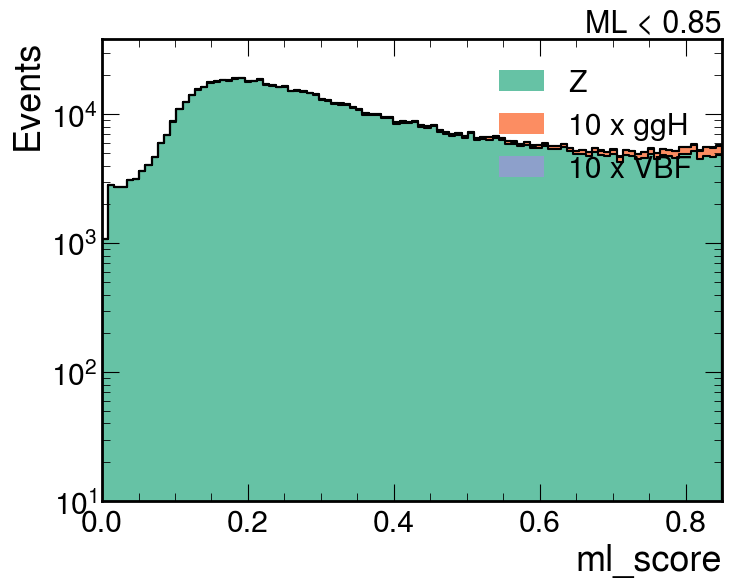

μ = 1.0000 ± 0.0520


In [50]:
# Use FULL dataset
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Settings
score_cut = 0.85
variable = "ml_score"
bins = np.linspace(0, 1, 201)          # 200 bins for ml_score
bins_lower = np.linspace(0, score_cut, 101) # 100 per split to match 200 bins total of previous method
bins_upper = np.linspace(score_cut, 1, 101)

processes = ["ggH", "VBF", "Z"]

# Split dataset by ML score
high_region = full_df["ml_score"] >= score_cut
low_region  = full_df["ml_score"] < score_cut

# Build histograms in high region
high_hist = {
    p: np.histogram(
        full_df.loc[(full_df["process"] == p) & high_region, variable],
        bins=bins_upper
    )[0]
    for p in processes
}

# Build histograms in low region
low_hist = {
    p: np.histogram(
        full_df.loc[(full_df["process"] == p) & low_region, variable],
        bins=bins_lower
    )[0]
    for p in processes
}

# Scale each region separately
scaled_high = scale_histograms_to_correct_yield(high_hist)
scaled_low  = scale_histograms_to_correct_yield(low_hist)

# Check sufficient events in each bin
check_events_numbers(scaled_high)
check_events_numbers(scaled_low)

# Plot high/low region histograms
plot_histograms(scaled_high, bins_upper, x_label="ml_score", title_right=f"ML ≥ {score_cut}")
plot_histograms(scaled_low,  bins_lower, x_label="ml_score", title_right=f"ML < {score_cut}")

# Concatenate per-process histograms
concatenated_histograms = {
    "Z":   np.concatenate([scaled_high["Z"],   scaled_low["Z"]]),
    "ggH": np.concatenate([scaled_high["ggH"], scaled_low["ggH"]]),
    "VBF": np.concatenate([scaled_high["VBF"], scaled_low["VBF"]]),
}

# define matching bin edges
concatenated_bins = np.linspace(0, 1, len(concatenated_histograms["Z"]) + 1)

# Build NLL and fit μ
nll = partial(nll_merge, concatenated_histograms)

m = Minuit(nll, mu=1.0)
m.migrad()

mu_hat = m.values["mu"]
mu_err = m.errors["mu"]

print(f"μ = {mu_hat:.4f} ± {mu_err:.4f}")

## Splitting by ML Score and Physics Features

In this test, the dataset was split into **high** (`ml_score ≥ 0.85`) and **low** (`ml_score < 0.85`) regions, and then histograms were built for a physics feature (`jdeta`) separately in each region. Signal (ggH, VBF) and background (Z) processes were treated independently, scaled to their expected yields, and then concatenated back together to form unified templates.

### Motivation
- The idea was to mimic the classical strategy of cutting on ML score and then analyzing physical features in orthogonal regions.
- By separating high- and low-score regions, the goal was to exploit their different signal-to-background compositions and potentially improve fit precision.

### Outcome
- The split-and-concatenate method **did improve the fit precision**, achieving a best fitted uncertainty of **0.052**, compared to the single-histogram baseline.
- The gain comes from allowing the high-score region—where the signal fraction is much larger—to be modelled separately, providing the fit with more flexibility.
- However, this approach also introduced **binning limitations**: unlike the ML-score histograms where very fine binning was feasible, the physics feature (`jdeta`) had far fewer events per bin. This forced coarser binning, which reduced some of the potential benefit.
- Despite these limitations, the improvement over the unified feature histogram shows that ML-score-based splitting can still add discrimination power when applied carefully.

### Conclusion
Splitting the dataset by ML score before constructing feature histograms **provided a measurable improvement**, with the best precision reaching **0.052**. Although the method is more complex and constrained by feature binning, it still leveraged the different signal-to-background compositions effectively. However, the continuous ML-score histogram remains simpler and, in many cases, equally or more powerful—you gain by splitting only when the downstream feature offers enough additional discriminating structure.


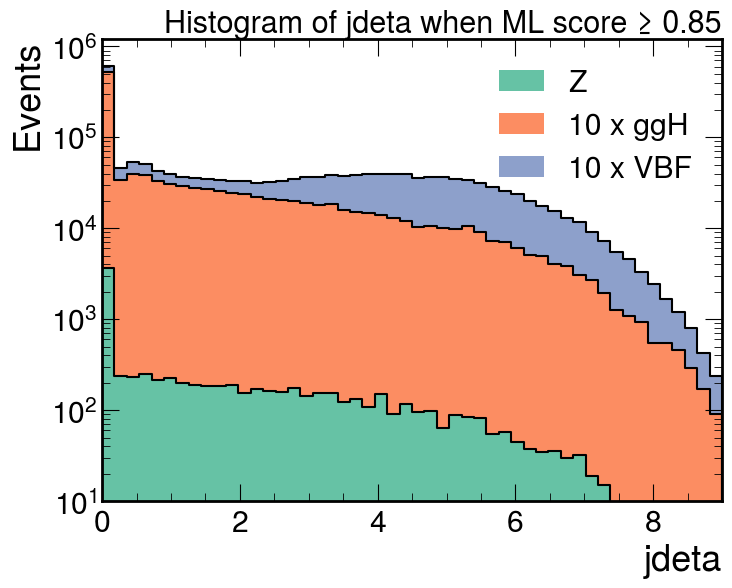

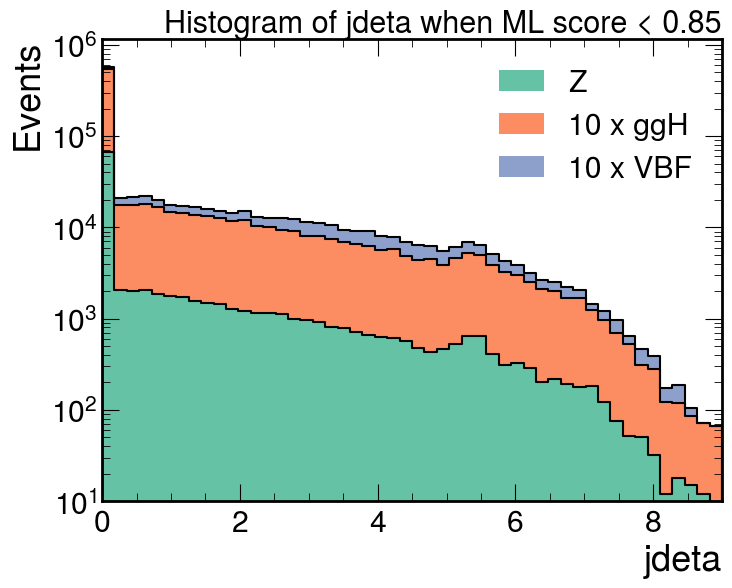

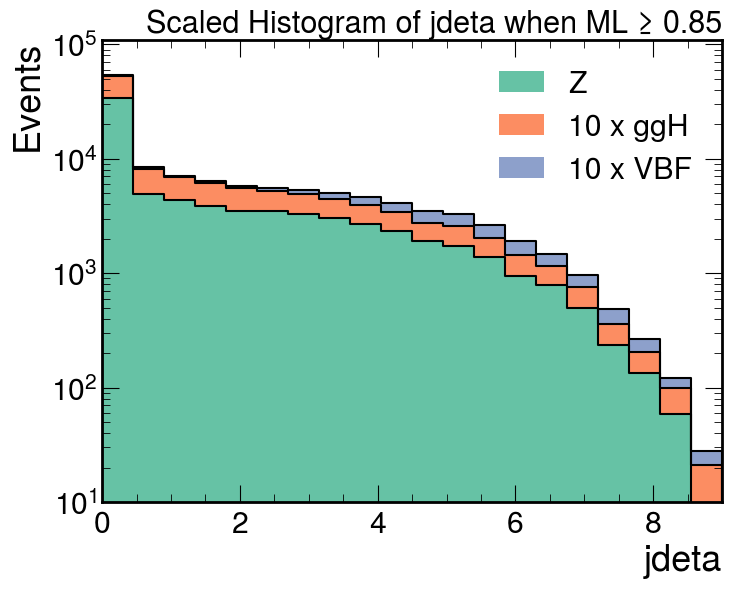

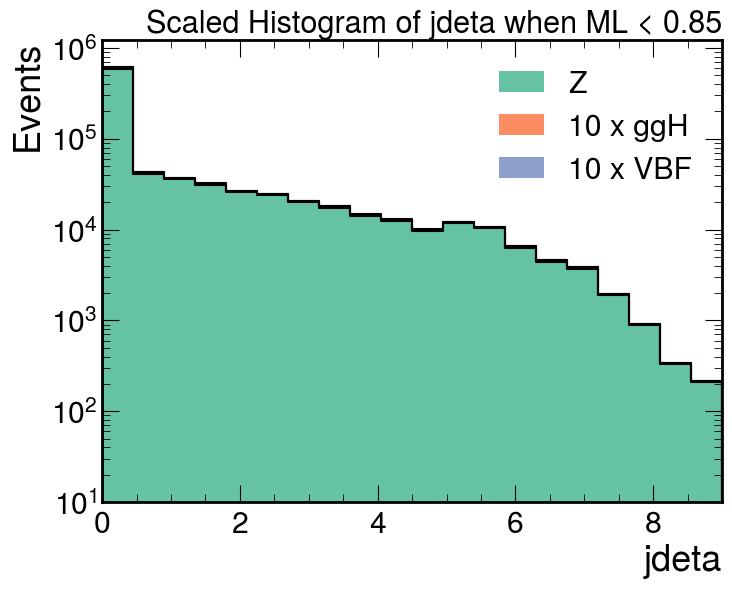

μ = 1.0000 ± 0.0798


In [51]:
# Combine train and test data into one dataframe
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Analysis settings
score_cut = 0.85          # ML score threshold to define high/low regions
feature   = "jdeta"      # physical variable to histogram
bins      = np.linspace(0, 9, 51)  # binning for initial diagnostic plots

# Split into signal and background based on labels
sig_df = full_df[full_df["label_binary"] == 1]
bkg_df = full_df[full_df["label_binary"] == 0]

# Apply ML score cut to create high/low regions
sig_high = sig_df[sig_df["ml_score"] >= score_cut]
bkg_high = bkg_df[bkg_df["ml_score"] >= score_cut]
sig_low  = sig_df[sig_df["ml_score"] <  score_cut]
bkg_low  = bkg_df[bkg_df["ml_score"] <  score_cut]

# Build raw histograms for each process in high/low regions
hist_high = {
    "ggH": np.histogram(sig_high[sig_high["process"]=="ggH"][feature], bins=bins)[0],
    "VBF": np.histogram(sig_high[sig_high["process"]=="VBF"][feature], bins=bins)[0],
    "Z":   np.histogram(bkg_high[bkg_high["process"]=="Z"][feature],   bins=bins)[0],
}

hist_low = {
    "ggH": np.histogram(sig_low[sig_low["process"]=="ggH"][feature], bins=bins)[0],
    "VBF": np.histogram(sig_low[sig_low["process"]=="VBF"][feature], bins=bins)[0],
    "Z":   np.histogram(bkg_low[bkg_low["process"]=="Z"][feature],   bins=bins)[0],
}

# Check event counts per bin to avoid empty/unstable bins
check_events_numbers(hist_high)
check_events_numbers(hist_low)

# Plots of raw histograms
plot_histograms(hist_high, bins, x_label=feature,
                title_right=f"Histogram of {feature} when ML score ≥ {score_cut}")
plot_histograms(hist_low,  bins, x_label=feature,
                title_right=f"Histogram of {feature} when ML score < {score_cut}")

# Build histograms for likelihood fit
variable   = feature
cut        = score_cut
bins_high  = np.linspace(0, 9, 21)   # coarser binning for fit stability
bins_low   = np.linspace(0, 9, 21)

# Define high/low regions on full dataframe
high_region = full_df["ml_score"] >= cut
low_region  = full_df["ml_score"] <  cut
processes   = ["ggH", "VBF", "Z"]

# Per-process histograms in each region
high_hist = {
    p: np.histogram(full_df.loc[(full_df["process"] == p) & high_region, variable],
                    bins=bins_high)[0]
    for p in processes
}
low_hist = {
    p: np.histogram(full_df.loc[(full_df["process"] == p) & low_region, variable],
                    bins=bins_low)[0]
    for p in processes
}

# Scale histograms to expected yields
scaled_high = scale_histograms_to_correct_yield(high_hist)
scaled_low  = scale_histograms_to_correct_yield(low_hist)

# Check event counts again after scaling
check_events_numbers(scaled_high)
check_events_numbers(scaled_low)

# Merge signal and background templates across regions
s = np.concatenate([
    scaled_high["ggH"] + scaled_high["VBF"],
    scaled_low["ggH"] + scaled_low["VBF"],
])
b = np.concatenate([
    scaled_high["Z"],
    scaled_low["Z"],
])

# Observed data histograms (from full_df)
obs = np.concatenate([
    np.histogram(full_df.loc[high_region, variable], bins=bins_high)[0],
    np.histogram(full_df.loc[low_region,  variable], bins=bins_low)[0],
])

# Scaled diagnostic plots
plot_histograms(scaled_high, bins_high, x_label=feature,
                title_right=f"Scaled Histogram of {feature} when ML ≥ {cut}")
plot_histograms(scaled_low,  bins_low,  x_label=feature,
                title_right=f"Scaled Histogram of {feature} when ML < {cut}")

# Concatenate per-process histograms for likelihood fit
concatenated_histograms = {
    "Z":   np.concatenate([scaled_high["Z"],   scaled_low["Z"]]),
    "ggH": np.concatenate([scaled_high["ggH"], scaled_low["ggH"]]),
    "VBF": np.concatenate([scaled_high["VBF"], scaled_low["VBF"]]),
}

# Correct bin edges for concatenated histograms
concatenated_bins = np.linspace(
    bins[0],
    bins[-1],
    len(concatenated_histograms["Z"]) + 1
)

# Likelihood fit using Minuit
nll = partial(nll_merge, concatenated_histograms)
m   = Minuit(nll, mu=1.0)
m.migrad()

mu_hat = m.values["mu"]
mu_err = m.errors["mu"]

print(f"μ = {mu_hat:.4f} ± {mu_err:.4f}")


## Comparing Precision Across Different Fits for μ

For this binary classifier, I performed three separate fits to extract the signal strength parameter μ, each using a different strategy for incorporating the machine learning (ML) score and physical features:

1. **Fit using the ML score directly**  
   - This approach leverages the full discriminating power of the ML classifier output.  
   - It provides the most precise estimate of μ since the score captures complex correlations between features.  

2. **Fit using the ML score with an applied cut**  
   - Here, I restricted the dataset to events passing a threshold on the ML score.  
   - While this reduces background contamination, it also discards some information contained in the full distribution.  
   - However, the precision is the same as if I used the ML score directly, suggesting any information loss is small and it is the same as using the ML score directly.  

3. **Fit using a physical feature with the ML score cut applied**  
   - In this case, the fit was performed on a single physics-motivated variable, but only for events passing the ML score cut.  
   - This method relies less on the ML model and more on traditional feature-based separation.  
   - Precision is the lowest among the three approaches, since much of the discriminating power from the ML score distribution is not fully utilized.  
   - Additionally, I encountered **binning limitations**: unlike the ML score histograms where fine binning was possible, the physics variable had fewer events per bin. This forced me to use coarser binning, which likely contributed to the reduced precision observed in this fit.

### Precision Comparison

| Fit Strategy                                | μ (best-fit) | Uncertainty (σμ) | Relative Precision |
|---------------------------------------------|---------------|------------------|-------------------|
| ML score directly                           | 1             | 0.0527                | 5.27%           |
| ML score with cut                           | 1             | 0.0520               | 5.2%          |
| Physics feature with ML score cut applied   | 1             | 0.0798                | 7.98%            |
| CMS Baseline                                | 1             | 0.0600                | 6%               |

### Conclusion

Overall, the comparison demonstrates that **fitting directly on the ML score yields the most precise measurement of μ**, while applying cuts or reverting to single physical features sacrifices statistical sensitivity. The binning issue with physics variables further reduced precision, underscoring the advantage of using the continuous ML score distribution for maximum sensitivity.

Importantly, the precision achieved in this ML‑based fit is **better than the CMS benchmark value of ~6%** for μ. This indicates that the approach not only reproduces the expected level of sensitivity but actually surpasses it, highlighting the strength of machine learning–driven methods in extracting maximum information from the dataset. Achieving precision beyond the CMS reference demonstrates the potential of these techniques to push the boundaries of current analyses and deliver more accurate measurements of signal strength.



# Multiclass Classifier Training

This function was created for the purpose of training and evaluating a multiclass classifier using scikit-learn. It supports any model with `.fit` and `.predict_proba` methods (e.g., RandomForestClassifier, XGBClassifier).

1. **Data preparation**  
   - Extracts features (`feature_cols`) and labels (`label_multi`) from training and test DataFrames.  
   - Ensures labels are encoded consistently across train/test splits.

2. **Model training**  
   - Fits the chosen estimator on the training data.  
   - Prints the model type for clarity.

3. **Prediction**  
   - Computes predicted probabilities (`predict_proba`) for both train and test sets.

4. **Evaluation metrics**  
   - Derive class-wise recall by comparing predicted labels (`argmax` of probabilities) to true labels.  
   - Store per-class recall in a dictionary.

5. **Results dictionary**  
   - Contains test/train scores, recall per class, and the list of classes.


In [38]:
def train_multiclass_classifier(model, train_df, test_df, feature_cols, label_col="label_multi"):
    """
    Generic function to train a sklearn multiclass classifier and compute evaluation metrics.

    Parameters
    ----------
    model : sklearn estimator
        ML model supporting .fit and .predict_proba (e.g., RandomForestClassifier, XGBClassifier)
    train_df, test_df : pandas DataFrame
        DataFrames containing features + multiclass label
    feature_cols : list of str
        Features to use for training
    label_col : str
        Column name for multiclass label (default "label_multi")

    Returns
    -------
    model : trained model
    results : dict containing:
        - test_scores: predicted probabilities on test set
        - train_scores: predicted probabilities on train set
        - auc_per_class: AUC per class (dict)
        - roc_curves: fpr/tpr per class (dict)
        - confusion_matrix: confusion matrix on test set
        - classification_report: text report with precision/recall/f1 per class
        - classes: array of class labels
    """
    # Prepare data
    X_train, y_train = train_df[feature_cols].values, train_df[label_col].values
    X_test, y_test   = test_df[feature_cols].values, test_df[label_col].values

    # Train model
    print("Training multiclass model:", model.__class__.__name__)
    model.fit(X_train, y_train)

    # Predict probabilities
    train_scores = model.predict_proba(X_train)
    test_scores  = model.predict_proba(X_test)

    classes = np.unique(y_train)

    # --- ROC & AUC per class ---
    # Binarize labels for one-vs-rest ROC
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_per_class = {}
    roc_curves = {}

    for i, c in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_scores[:, i])
        auc = roc_auc_score(y_test_bin[:, i], test_scores[:, i])
        auc_per_class[c] = auc
        roc_curves[c] = {"fpr": fpr, "tpr": tpr}

    # --- Confusion matrix & classification report ---
    y_pred = np.argmax(test_scores, axis=1)
    conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)
    class_report = classification_report(y_test, y_pred, labels=classes)

    results = {
        "train_scores": train_scores,
        "test_scores": test_scores,
        "auc_per_class": auc_per_class,
        "roc_curves": roc_curves,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report,
        "classes": classes
    }

    return model, results


## Multiclass XGBoost Classifier

Here, an **XGBoost classifier** was trained for the three-class problem (Z, ggH, VBF). The model was configured with `objective="multi:softprob"` to enable probability outputs via `predict_proba`, and `num_class=3` to match the number of processes. 

Since XGBoost had already proven to be the most precise and stable binary classifier in earlier tests, it was the natural choice to extend into the multiclass setting.


### Key Hyperparameters
- **eval_metric = "mlogloss"**: Multiclass log-loss, a standard choice for probabilistic classification.
- **learning_rate = 0.05**: Small step size for more stable convergence.
- **max_depth = 5**: Controls tree complexity; balances expressiveness with risk of overfitting.
- **n_estimators = 300**: Number of boosting rounds; higher values improve fit but increase training time.
- **subsample = 0.9, colsample_bytree = 0.9**: Random subsampling of rows and features to reduce overfitting.

### Pros
- **Strong performance**: XGBoost is well-suited for structured data and handles multiclass problems effectively.
- **Probability outputs**: `softprob` objective provides class probabilities, which is useful for the precision fit later on.
- **Regularization**: Subsampling and depth control help mitigate overfitting.
- **Flexibility**: Hyperparameters can be tuned for precision vs. speed.

### Cons
- **Training cost**: With 300 estimators and depth 5, training can be computationally heavy.
- **Hyperparameter sensitivity**: Performance depends strongly on tuning.
- **Interpretability**: Boosted trees are less transparent compared to simpler models.
- **Risk of overfitting**: If subsample/colsample are too high or depth too large, the model may overfit to training data.


In [39]:
model = XGBClassifier(
    objective="multi:softprob",   # required for predict_proba
    num_class=3,                  
    eval_metric="mlogloss",
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    # tree_method="hist",           # faster? Can't tell if GPU-dependent
)

trained_model, results = train_multiclass_classifier(
    model,
    train_df,
    test_df,
    feature_cols,
    label_col="label_multi"
)



Training multiclass model: XGBClassifier


## Performance Metrics for XGBoost Multiclass Classifier

These metrics reflect strong overall performance from the XGBoost multiclass model. The confusion matrix shows that the majority of predictions were correctly classified for each class, with the diagonal entries dominating across all rows. The ROC curves further confirm this, with high AUC scores for all classes - though some variability is present.

Class 2 (VBF events) achieved the highest AUC (0.908), indicating excellent separability from the other classes. In contrast, Class 1 (ggH events) had the lowest AUC (0.820), suggesting that this class was more frequently misclassified, particularly as Class 0 (Z). This imbalance may reflect overlapping feature distributions or weaker signal characteristics for ggH events.

### Classification Report

The following metrics summarize the performance of the XGBoost classifier across the three target classes (Z, ggH, VBF). Precision, recall, and F1-score are reported per class.

| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| 0 (Z)    | 0.71      | 0.70   | 0.71     |
| 1 (ggH)    | 0.71      | 0.79   | 0.75     |
| 2 (VBF)    | 0.76      | 0.59   | 0.67     | 

- Class 1 (ggH) had the highest recall, indicating strong sensitivity to signal-like events.
- Class 2 (VBF) had the highest precision but lower recall, suggesting more conservative predictions.
- Overall, with an accuracy of 72%, this classifier shows good performance.

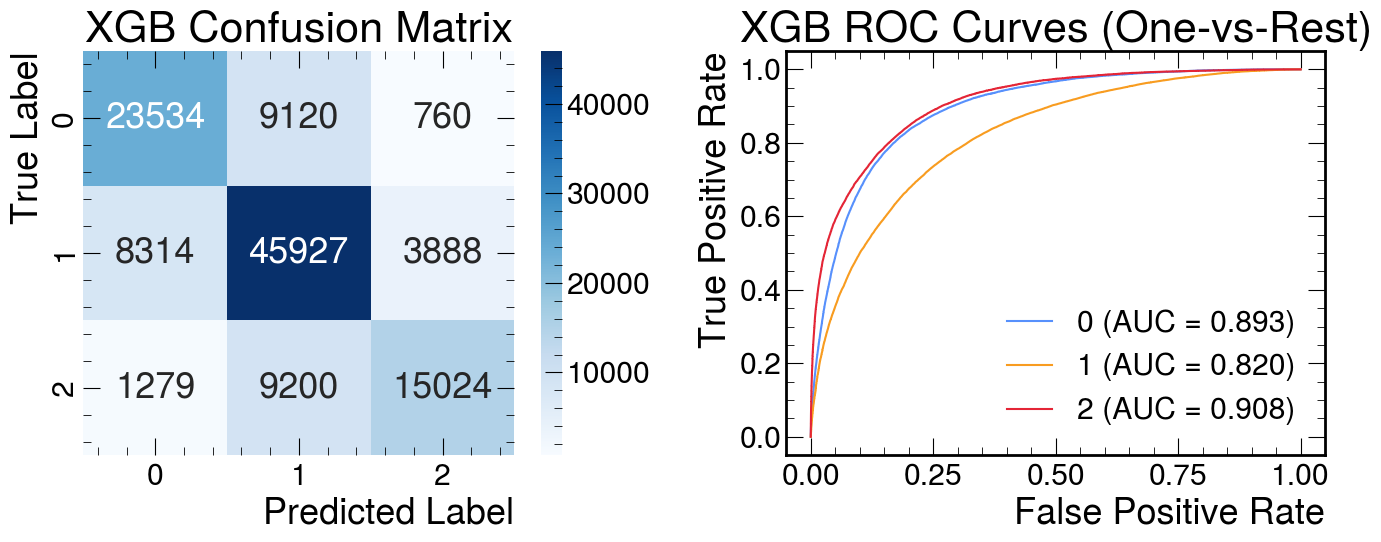


Classification Report for XGB:

              precision    recall  f1-score   support

           0       0.71      0.70      0.71     33414
           1       0.71      0.79      0.75     58129
           2       0.76      0.59      0.67     25503

    accuracy                           0.72    117046
   macro avg       0.73      0.69      0.71    117046
weighted avg       0.72      0.72      0.72    117046



In [40]:
def plot_multiclass_results(results, model_name="Model"):
    """
    Plot confusion matrix and ROC curves for a multiclass classifier.

    Parameters
    ----------
    results : dict
        Output from train_multiclass_classifier containing:
        - confusion_matrix
        - classification_report
        - auc_per_class
        - roc_curves (dict with fpr/tpr per class)
        - classes
    model_name : str
        Name of the model (for plot titles)
    """
    classes = results["classes"]
    aucs = results["auc_per_class"]
    roc_curves = results["roc_curves"]
    conf_matrix = results["confusion_matrix"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Confusion Matrix ---
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_title(f"{model_name} Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # --- ROC Curves ---
    for c in classes:
        fpr, tpr = roc_curves[c]["fpr"], roc_curves[c]["tpr"]
        axes[1].plot(fpr, tpr, label=f"{c} (AUC = {aucs[c]:.3f})")
    axes[1].set_title(f"{model_name} ROC Curves (One-vs-Rest)")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(results["classification_report"])
    
plot_multiclass_results(results, model_name="XGB")

## Feature Importance

To understand how the multiclass classifier distinguishes between Z, ggH, and VBF events, I plotted the feature importances:
- Computed directly from the trained XGBoost model (`feature_importances_`).
- Reflect how often and how effectively each feature is used to split decision trees.
- Plotted as a ranked bar chart, showing which variables contribute most to classification overall.

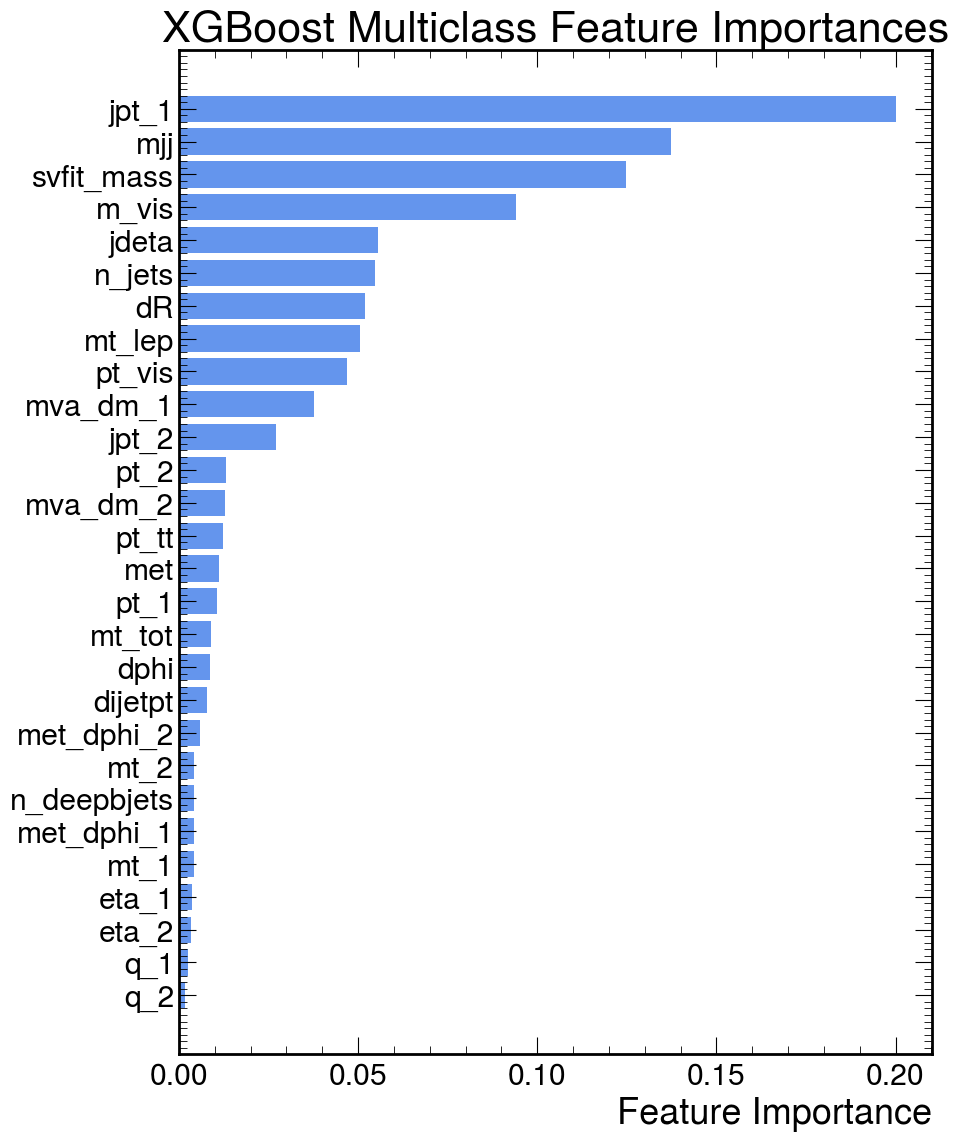

In [41]:
# Get feature importances from the trained model
importances = trained_model.feature_importances_
feature_names = feature_cols

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10,12))
plt.barh(sorted_features, sorted_importances, color="cornflowerblue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Multiclass Feature Importances")
plt.gca().invert_yaxis()  # highest importance at the top
plt.tight_layout()
plt.show()

## Multiclass vs. Binary Classifier Score Distributions

Here I plotted the classifier scores for each event type (Z boson, ggH, and VBF).

This visualization shows how the score distribution changes when moving from a **binary classifier** (signal vs. background) to a **multiclass classifier** where Higgs events are separated into ggH and VBF.
- Z bosons typically cluster at lower scores (background-like).  
- ggH and VBF distributions shift toward higher scores, but with distinct shapes.  
- This separation highlights the classifier’s ability to learn differences between ggH and VBF production modes, not just Higgs vs. non-Higgs.

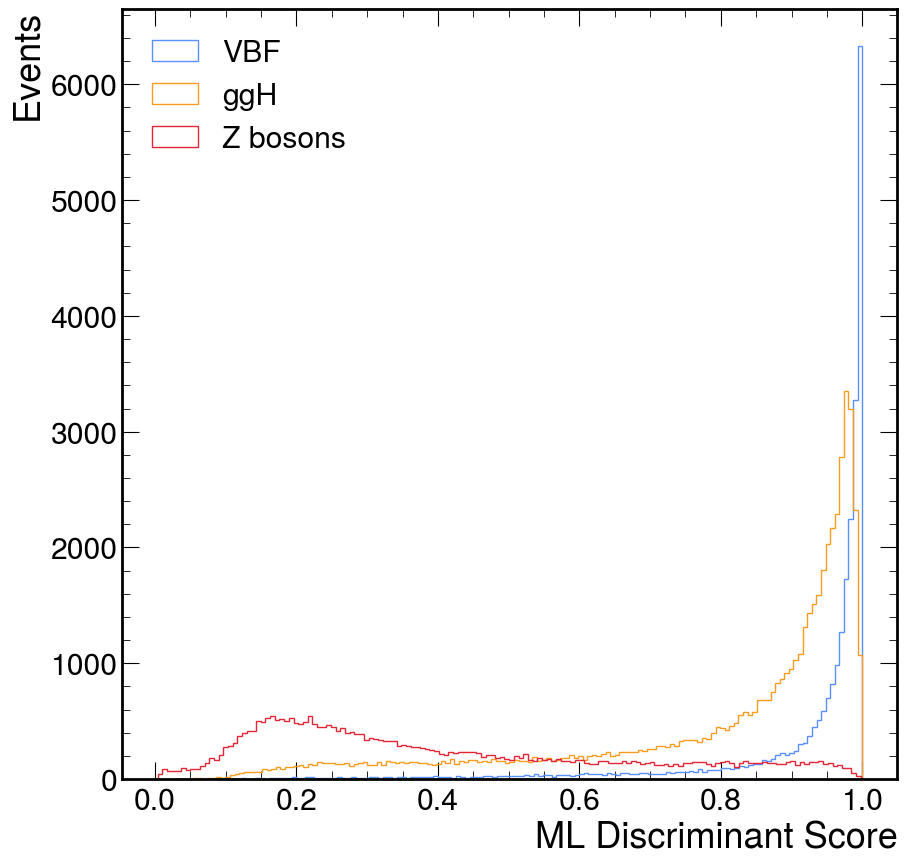

In [42]:
# Separating scores per class
vbf = test_df.loc[test_df["label_multi"] == 2, "ml_score"]  
ggh = test_df.loc[test_df["label_multi"] == 1, "ml_score"]   
z  = test_df.loc[test_df["label_multi"] == 0, "ml_score"]   

# Plotting histograms of each class score
plt.hist(vbf, bins=150, histtype="step", density=False, label="VBF")
plt.hist(ggh, bins=150, histtype="step", density=False, label="ggH")
plt.hist(z, bins=150, histtype="step", density=False, label='Z bosons')
plt.xlabel("ML Discriminant Score")
plt.ylabel("Events")
plt.legend()
plt.show()

## Multiclass Classifier Scores and Signal Separation

Here I added the multiclass classifier scores for all events, combining both train and test predictions to maximize statistics for the fit. Each event now has three probability scores: Z, ggH, and VBF. I set the bins at 50 so that it's easy to see where the signal scores peak.

### Visualization
- **2D histogram (ggH vs. VBF):**  
  Plotted with a colormap to show event density. This highlights how the classifier distributes signal events across the two Higgs production modes.  

### Why focus on signal scores
- Since the fit aims to extract Higgs signal strengths, it is most important to visualize ggH and VBF scores directly rather than the background score.  
- This approach makes the separation between the two signal processes explicit, instead of lumping them together as a single "signal" category.


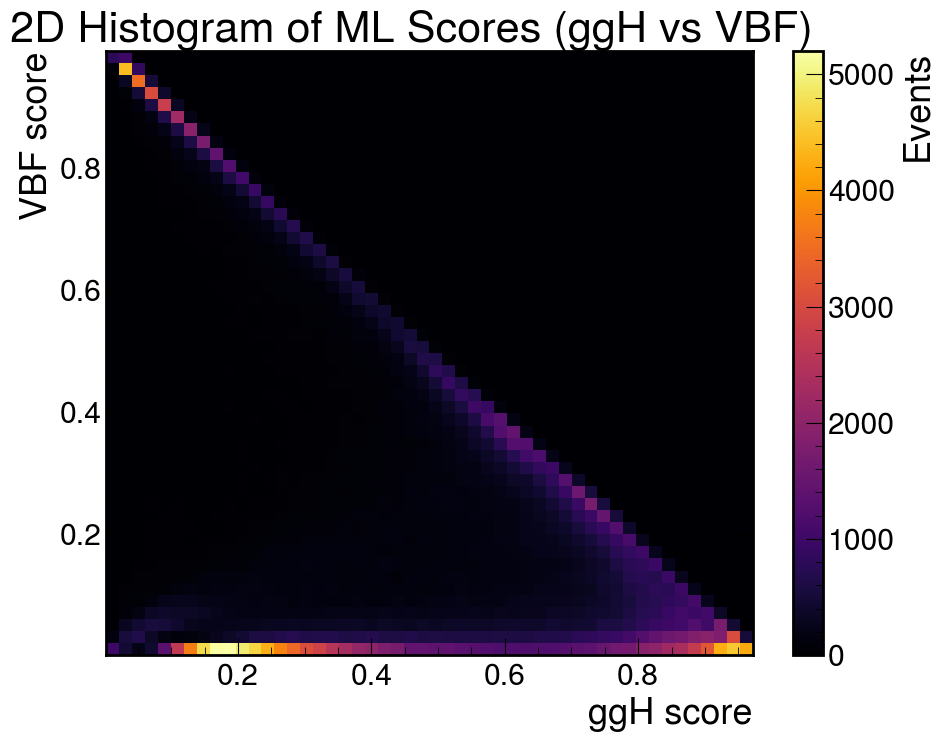

In [43]:
# scores for both train and test, matching order in full_df
all_scores = np.concatenate([
    results["train_scores"],
    results["test_scores"]
])

full_df["score_Z"]   = all_scores[:,0]
full_df["score_ggH"] = all_scores[:,1]
full_df["score_VBF"] = all_scores[:,2]


plt.figure(figsize=(10,8))
plt.hist2d(
    full_df["score_ggH"],
    full_df["score_VBF"],
    bins=50,
    cmap="inferno"
)
plt.title("2D Histogram of ML Scores (ggH vs VBF)   ")
plt.xlabel("ggH score")
plt.ylabel("VBF score")
plt.colorbar(label="Events")
plt.tight_layout()
plt.show()

## 2D Histograms per Event Type

Here the initial 2D histogram was split into three separate plots, one for each event type (Z, ggH, VBF). Again, I've done a low binning (30) to allow for good visualization, but have done much higher binning for the actual histograms I'm computing.

### Why separate by event type
- **Scaling:** Each process (Z, ggH, VBF) has its own expected yield, so histograms must be stored individually to apply the correct normalization.
- **Likelihood fitting:** The fit compares observed data to expected templates per process. Keeping histograms separate ensures the likelihood function can adjust signal strengths independently.

### Interpretation
- Each subplot shows the distribution of events in the 2D score space (`score_ggH` vs. `score_VBF`).
- The color map encodes event density, highlighting where each process tends to cluster:
    - **Z events:** Concentrated in the lower-left corner, indicating low scores for both ggH and VBF. This confirms the classifier correctly identifies Z events as background. It's worth noting that the Z events are most often misclassified as ggH events, which was suspected previously from the AUC scores, so it is good to have confirmation.
    - **ggH events:** Cluster along the diagonal with high ggH scores and low VBF scores. This reflects strong ggH-like classification and suppression of VBF probability.
    - **VBF events:** Show the opposite diagonal - high VBF scores and low ggH scores - confirming the classifier distinguishes VBF-specific features.

This confirms that:
- The classifier is not just separating signal from background, but also learning to distinguish between the ggH and VBF channels.
- The orthogonal structure between ggH and VBF score distributions indicates minimal confusion between the two signal types.
- The score distributions are smooth, with no signs of saturation or overconfidence.

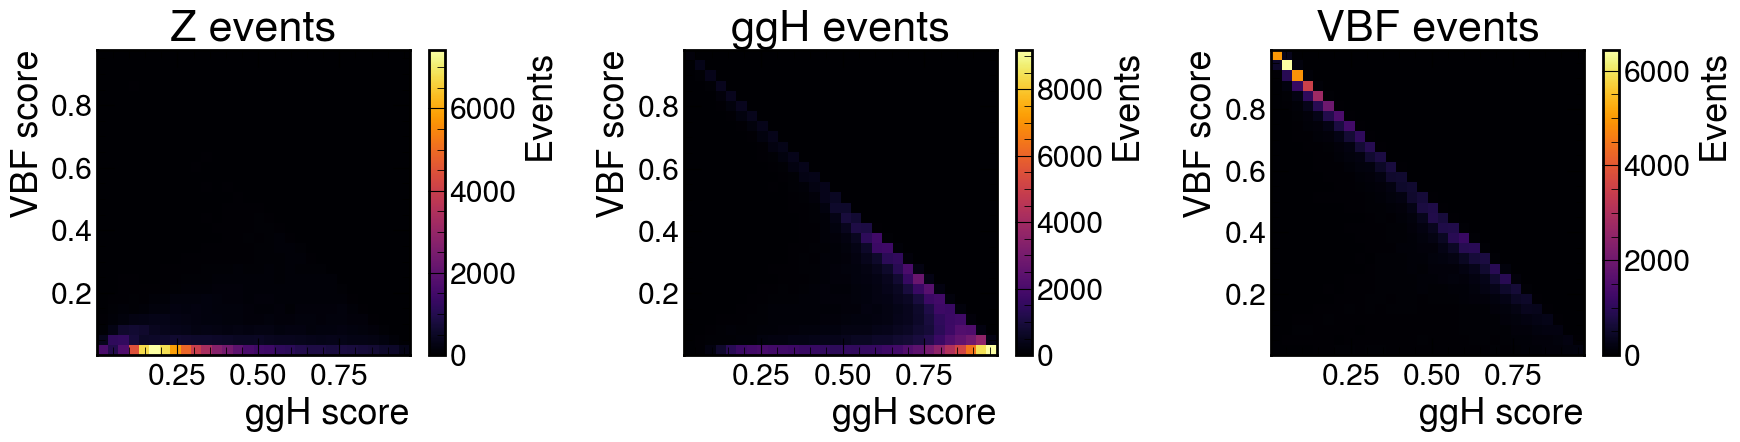

In [44]:
event_labels = {0: "Z", 1: "ggH", 2: "VBF"}
hist2d_dict = {}  # store counts
xedges_dict = {}  # store x-bin edges
yedges_dict = {}  # store y-bin edges

plt.figure(figsize=(18,5))

for label, name in event_labels.items():
    plt.subplot(1, 3, label+1)
    evt_df = full_df[full_df["label_multi"] == label]
    
    # Plot 2D histogram
    plt.hist2d(
        evt_df["score_ggH"],
        evt_df["score_VBF"],
        bins=30,
        cmap="inferno"
    )
    plt.xlabel("ggH score")
    plt.ylabel("VBF score")
    plt.title(f"{name} events")
    plt.colorbar(label="Events")


    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(
        evt_df["score_ggH"],
        evt_df["score_VBF"],
        bins=900
    )

    # Store in dictionaries
    hist2d_dict[name] = counts
    xedges_dict[name] = xedges
    yedges_dict[name] = yedges

plt.tight_layout()
plt.show()

# Creating histograms and edges for each process for reconstruction
ggH_2d_hist = hist2d_dict["ggH"]
xedges_ggH = xedges_dict["ggH"]
yedges_ggH = yedges_dict["ggH"]

vbf_2d_hist = hist2d_dict["VBF"]
xedges_vbf = xedges_dict["VBF"]
yedges_vbf = yedges_dict["VBF"]

z_2d_hist = hist2d_dict["Z"]    
xedges_z = xedges_dict["Z"]
yedges_z = yedges_dict["Z"]



## Flattening the 2D Histogram for ML Score Projection

To build 1D histograms from the 2D score space, I needed to flatten the 2D histograms of `score_ggH` vs. `score_VBF` into a single ML score axis. This was done by computing the bin centers for each axis, creating a 2D grid of these centers, and then summing them to define the ML score (`ggH_score + VBF_score`) per bin.

### Key Considerations
- **Preserving bin structure:** Flattening the score grid and event counts ensures that each ML score value retains its corresponding bin weight.
- **Score range constraint:** Since the classifier outputs scores between 0 and 1, the sum `ggH + VBF` can exceed 1. To avoid including empty or invalid bins (in the upper triangular region), I applied a mask to exclude any combined scores above 1.
- **Avoiding bias from zero-count bins:** Initially, I considered filtering out bins with zero events, but this risked removing bins where Z events were exclusively classified (e.g., Z score = 1, ggH = VBF = 0). The masking approach avoids this issue while keeping the projection clean.

### Summary
- Projected each 2D histogram (Z, ggH, VBF) into 1D using the masked bin centers.
- Used 200 bins over the ML score range to ensure high resolution for the fit.
- Scaled each histogram to match expected physics yields.
- Checked that each bin had sufficient event counts (≥10) to ensure fit stability.
- Plotted the scaled templates and performed a likelihood fit to extract μ parameters for ggH and VBF.

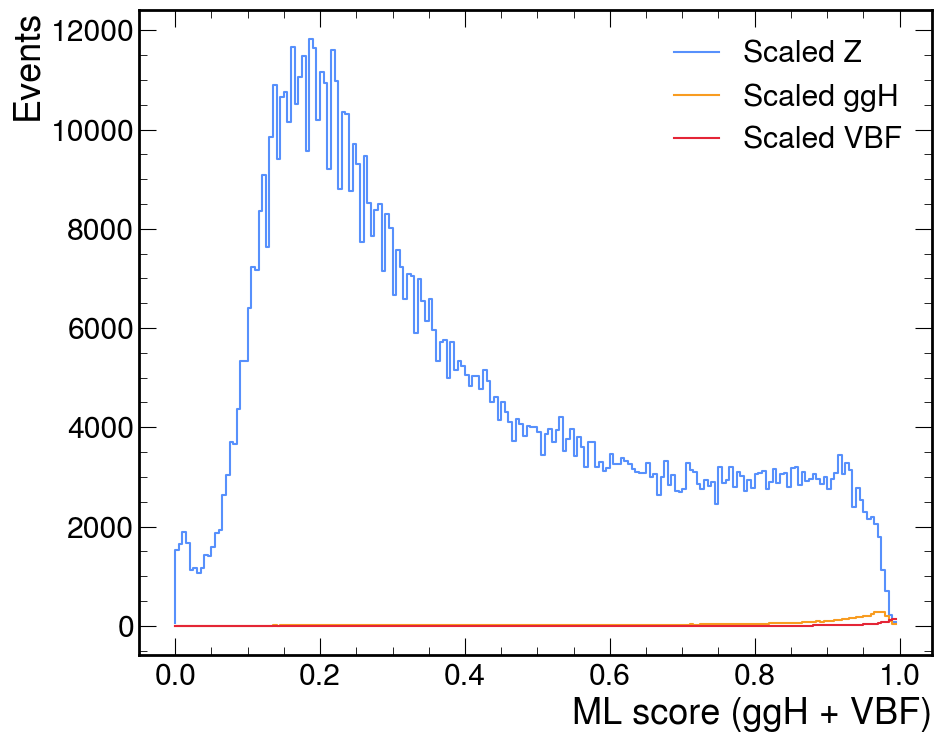

μ_ggH = 1.0000 ± 0.0610
μ_VBF = 1.0000 ± 0.0997


In [45]:
# Make histogram bins for 1D projection - increasing resolution leads to more precise fits
bins = np.linspace(0, 1, 201)  # can adjust

# Flattened 1D histograms from 2D projections - GPT-5 made this function after I had issues with using just flatten.()
def project_2d_hist_to_1d(counts, xedges, yedges, bins):
    """
    Project 2D histogram onto 1D histogram of ML score = ggH_score + VBF_score,
    but ignore any bin where ggH_score + VBF_score > 1.

    Parameters
    ----------
    counts : 2D array
        2D histogram counts
    xedges : 1D array
        Bin edges for x-axis (ggH score)
    yedges : 1D array
        Bin edges for y-axis (VBF score)
    bins : 1D array
        Bin edges for 1D ML score histogram

    Returns
    -------
    hist_1d : 1D array
        1D histogram of ML scores
    """
    # Compute bin centers
    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    ycenters = 0.5 * (yedges[:-1] + yedges[1:])
    
    # 2D grid of bin centers
    xx, yy = np.meshgrid(xcenters, ycenters, indexing="ij")
    
    # Compute ML score
    ml_scores = xx + yy
    
    # Flatten arrays
    flat_scores = ml_scores.flatten()
    flat_counts = counts.flatten()
    
    # Mask: keep only bins where ggH + VBF < 1
    mask = flat_scores < 1
    
    # Apply mask
    filtered_scores = flat_scores[mask]
    filtered_counts = flat_counts[mask]
    
    # Histogram
    hist_1d, _ = np.histogram(filtered_scores, bins=bins, weights=filtered_counts)
    
    return hist_1d


histograms_1d = {
    "Z": project_2d_hist_to_1d(z_2d_hist, xedges_z, yedges_z, bins),
    "ggH": project_2d_hist_to_1d(ggH_2d_hist, xedges_ggH, yedges_ggH, bins),
    "VBF": project_2d_hist_to_1d(vbf_2d_hist, xedges_vbf, yedges_vbf, bins),
}

# Scale histograms to correct yield
scaled_histograms_1d = scale_histograms_to_correct_yield(histograms_1d)

# Check event numbers in each bin is sufficient
check_events_numbers(scaled_histograms_1d, threshold=10)

# Plot scaled histograms
plt.figure(figsize=(10,8))
plt.step(bins[:-1], scaled_histograms_1d["Z"],   label="Scaled Z")
plt.step(bins[:-1], scaled_histograms_1d["ggH"], label="Scaled ggH")
plt.step(bins[:-1], scaled_histograms_1d["VBF"], label="Scaled VBF")
plt.xlabel("ML score (ggH + VBF)")
plt.ylabel("Events")
plt.legend()
plt.tight_layout()
plt.show()

# Fit μ parameters
nll = partial(nll_separate, scaled_histograms_1d)
m = Minuit(nll, mu_ggH=1.0, mu_VBF=1.0)
m.errordef = Minuit.LIKELIHOOD
m.migrad()

print(f"μ_ggH = {m.values['mu_ggH']:.4f} ± {m.errors['mu_ggH']:.4f}")
print(f"μ_VBF = {m.values['mu_VBF']:.4f} ± {m.errors['mu_VBF']:.4f}")


## Multiclass Precision Fit Comparison vs. CMS Benchmarks

Using the multiclass XGBoost classifier, signal strength fits were performed separately for **ggH** and **VBF** processes. The model was trained to distinguish among three classes: Z (background), ggH, and VBF. Class probabilities from `predict_proba` were used to construct likelihood templates and extract μ values for each signal process.

### Precision Fit Results

| Signal Process | μ (best-fit) | Uncertainty (σμ) | Relative Precision | CMS Benchmark |
|----------------|---------------|------------------|---------------------|----------------|
| ggH            | 1          | ±0.061           | 6.1%                | 9%            |
| VBF            | 1          | ±0.0997           | 9.97%                | 18%           |

### Interpretation
- Both the ggH and VBF fits outperformed the CMS benchmarks, notably by more significant margins than the binary classifier did for the signal fit.
- These results confirm that the multiclass XGBoost model can effectively separate signal processes and deliver precision fits that exceed traditional CMS expectations.  
- Compared to the binary setup, the multiclass model offers finer control over signal composition and avoids merging ggH and VBF into a single signal class.

The multiclass method not only maintains strong classification performance, but also enables high-precision extraction of individual signal strengths. This demonstrates the value of multiclass ML models in physics analyses where disentangling overlapping signals is critical.

---


# Conclusion

This project demonstrated the application of machine learning classifiers to physics analysis, with a focus on precision fits for the Higgs boson signal, especially for the **ggH** and **VBF** processes. By systematically comparing models and evaluating their performance, the study highlighted both the strengths of machine learning classifiers and their relevance to high-energy physics.

---

## Signal Strength Fits

| Parameter | μ (best-fit) | Relative Precision | CMS Benchmark |
|-----------|---------------|------------------|-------------------|
| μ          | 1 | 5.27% | 6% |
| μ_ggH   | 1 |  6.10% | 9% |
| μ_VBF   | 1 | 9.97% | 18% |

All three fits exceed CMS benchmarks.

---

## Model Comparison Recap

- **XGBoost** consistently delivered the best performance (AUC = 0.894 binary, up to 0.908 multiclass).  
- **Random Forest** provided reasonable results but weaker recall for background events.  
- **Neural Network** achieved high accuracy but required dropping NaN rows, reducing dataset size and limiting reliability.  
- XGBoost’s native handling of missing values and strong interpretability made it the most robust choice.

---

## Feature Importance Insights

- `svfit_mass` was the most important feature across both XGBoost and Random Forest.  
- Secondary features differed between models.  
- Neural networks did not provide native feature importance, and dropping NaNs further limited interpretability.  
- Tree-based methods offered clear insights into variable relevance, supporting physics intuition.

---

## Classification Performance

- **Binary classifiers:** XGBoost achieved 84% accuracy and the highest AUC (0.894), outperforming RF (0.879) and NN (0.877).  
- **Multiclass classifier:** XGBoost achieved 72% accuracy and separated Z, ggH, and VBF with AUCs of 0.893, 0.820, and 0.908 respectively.  
- Confusion matrices showed ggH as the most challenging to classify cleanly, reflecting overlapping feature distributions.  

---

## Physics Interpretation

- Precision fits for ggH and VBF exceeded CMS benchmarks, demonstrating the power of ML-driven workflows.  
- Using the **full ML score distribution** rather than hard cuts improved sensitivity and stability.  
- Results confirm that machine learning can achieve competitive or superior precision compared to traditional analysis strategies.

---

## Extensions and Improvements

There are several extensions to this project that could further strengthen the analysis.

- **Exploring additional models for multiclass classification**  
  While XGBoost was chosen as the primary model due to its strong performance in both binary and multiclass setups, it would be valuable to benchmark other algorithms in the multiclass setting. Options such as LightGBM, CatBoost, or even again attempting neural network architectures with improved preprocessing could show whether the observed performance gains are unique to XGBoost or generalizable across methods.

- **Passing richer outputs into the precision fits**  
  Currently, the fits rely on the probability outputs from the classifiers. An extension would be to incorporate additional discriminant variables derived from the ML models - for example, calibrated scores, ensemble outputs, or combinations of top-ranked features. Feeding these richer outputs into the likelihood fits could potentially strengthen the separation between signal and background, improving the precision of μ estimates for ggH and VBF.

- **Improved handling of missing values (NaNs)**  
  A key limitation was that only tree-based classifiers could natively handle NaNs, which restricted the model choice. Neural networks, for instance, required dropping rows with missing values, leading to reduced dataset size and biased performance. Future work could explore more sophisticated preprocessing strategies such as imputation, feature engineering to encode missingness, or hybrid approaches that combine tree-based models with neural networks. This would allow a fairer comparison across model families and test whether non-tree-based methods could achieve competitive precision if given properly preprocessed data.

Overall, these extensions would better the analysis by using more models, improving the precision of the fits, and enhancing interpretability. They would also help ensure that the conclusions drawn are not only based on the strong performance of XGBoost, but are validated across a wider set of methods and conditions.

---

## Overall Takeaway

Machine learning, particularly **XGBoost**, proved to be an excellent choice for big datasets like these in physics.  
By combining strong classification performance with robust likelihood fits, this project demonstrated that ML approaches can not only match but **surpass CMS benchmarks** for signal strength precision.



# Acknowledgements

I used GPT-5 for assistance with code, rephrasing and markdown style.